# Importing Dataset / Libraries

#### Skip first 3 Cells if dataset is downloaded already 

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = '' # username
os.environ['KAGGLE_KEY'] = '' # key

In [ ]:
!kaggle datasets download -d surekharamireddy/fraudulent-claim-on-cars-physical-damage

fraudulent-claim-on-cars-physical-damage.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q fraudulent-claim-on-cars-physical-damage.zip

replace test_2021.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace training data/training data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


#### Start from here if dataset is downloaded already

In [ ]:
%%capture
!pip install shap
!pip install keras-tuner

In [ ]:
# Import necessary libraries
import time 
import pickle
import shap
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import seaborn as sns

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer

# For feature selection
from sklearn.feature_selection import SelectKBest,mutual_info_classif

# For clustering in feature engineering
from sklearn.cluster import KMeans, AgglomerativeClustering

# For sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

# For hyperopt - used for Bayesian hyperparameter tuning
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope

# For modelling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier  
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import keras_tuner as kt






In [ ]:
df = pd.read_csv("training data/training data.csv")
test_data = pd.read_csv("test_2021.csv")

In [ ]:
df.head()

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,...,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
0,1,46,M,1.0,85,38301,1,1,Rent,80006,...,74,Broker,0,7530.940993,9.0,Compact,12885.45235,white,16161.33381,0
1,3,21,F,0.0,75,30445,0,1,Rent,15021,...,79,Online,0,2966.024895,4.0,Large,29429.45218,white,28691.96422,0
2,4,49,F,0.0,87,38923,0,1,Own,20158,...,0,Broker,0,6283.888333,3.0,Compact,21701.18195,white,22090.94758,1
3,5,58,F,1.0,58,40605,1,0,Own,15024,...,99,Broker,1,6169.747994,4.0,Medium,13198.27344,other,38329.58106,1
4,6,38,M,1.0,95,36380,1,0,Rent,50034,...,7,Broker,0,4541.387150,7.0,Medium,38060.21122,gray,25876.56319,0


In [ ]:
test_data.head()

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,...,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight
0,2,39,M,1.0,73,36633,1,0,Own,50048,...,0.0,25,Phone,0,5196.552552,8.0,Large,24360.59273,silver,26633.27819
1,9,56,M,1.0,63,40252,1,1,Own,85068,...,1.0,50,Broker,1,7381.165248,6.0,Large,39710.42665,other,15875.34874
2,11,39,F,0.0,75,36634,1,1,Own,20115,...,0.0,98,Broker,1,5612.123938,7.0,Medium,50327.56618,silver,21365.05932
3,13,33,M,1.0,72,34960,0,1,Own,50006,...,1.0,45,Phone,0,7957.267641,2.0,Medium,23457.35282,black,26707.46021
4,14,24,F,1.0,70,31776,1,1,Rent,20122,...,1.0,11,Online,0,6232.195932,1.0,Medium,18238.39202,silver,22949.73744


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17998 entries, 0 to 17997
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   claim_number             17998 non-null  int64  
 1   age_of_driver            17998 non-null  int64  
 2   gender                   17998 non-null  object 
 3   marital_status           17993 non-null  float64
 4   safty_rating             17998 non-null  int64  
 5   annual_income            17998 non-null  int64  
 6   high_education_ind       17998 non-null  int64  
 7   address_change_ind       17998 non-null  int64  
 8   living_status            17998 non-null  object 
 9   zip_code                 17998 non-null  int64  
 10  claim_date               17998 non-null  object 
 11  claim_day_of_week        17998 non-null  object 
 12  accident_site            17998 non-null  object 
 13  past_num_of_claims       17998 non-null  int64  
 14  witness_present_ind   

# Data Cleaning

In [ ]:
# create a function to show missing value info
def get_missing_values_info(df):

    # find missing values in each column
    count_missing = df.isnull().sum()

    # get missing values as percent
    percent_missing = (100 * count_missing / df.shape[0]).round(1)

    # Make dataframe with the results
    missing_df = pd.DataFrame({'Count Missing':count_missing,
                               'Percent Missing':percent_missing})

    # sort values by percent missing
    missing_df = missing_df.sort_values('Percent Missing', ascending=False)

    # find percent of columns with missing values and compare to total number of columns
    missing_values_list = df.columns[df.isnull().any()].tolist()
    cols_missing_vals = len(missing_values_list)
    df_cols = df.shape[1]

    print(f'Columns With Missing Values: {cols_missing_vals}')
    print(f'Total Columns: {df_cols}')
    print(f'Percent of Columns with Missing Values: {round(cols_missing_vals/df_cols*100,1)}%')

    return missing_df

In [ ]:
get_missing_values_info(df)

Columns With Missing Values: 4
Total Columns: 25
Percent of Columns with Missing Values: 16.0%


,Count Missing,Percent Missing
witness_present_ind,132,0.7
claim_est_payout,17,0.1
claim_number,0,0.0
past_num_of_claims,0,0.0
vehicle_weight,0,0.0
vehicle_color,0,0.0
vehicle_price,0,0.0
vehicle_category,0,0.0
age_of_vehicle,8,0.0
policy_report_filed_ind,0,0.0


In [ ]:
# Since the count rows with of missing values are small in comparision to dataset we can choose to drop these rows.
df.dropna(inplace = True)

In [ ]:
# Drop irrelevant columns
df.drop(['zip_code','claim_number'],axis=1,inplace=True)

In [ ]:
df.describe()

,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight,fraud
count,17836.000000,17836.000000,17836.000000,17836.000000,17836.000000,17836.000000,17836.000000,17836.000000,17836.000000,17836.000000,17836.000000,17836.000000,17836.000000,17836.000000,17836.000000
mean,43.682216,0.712660,73.586118,37366.488058,0.699260,0.577091,0.505046,0.232507,49.421787,0.600247,4975.398712,5.010821,23097.101458,23028.842460,0.156762
std,11.955564,0.452534,15.326413,2946.046398,0.458593,0.494035,0.955487,0.422442,33.678203,0.489861,2216.775833,2.259639,11999.398851,12056.598498,0.363586
min,18.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.639432,0.000000,2457.329316,2429.429302,0.000000
25%,35.000000,0.000000,65.000000,35554.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,3336.697272,3.000000,14279.914690,14164.412338,0.000000
50%,43.000000,1.000000,76.000000,37610.000000,1.000000,1.000000,0.000000,0.000000,50.000000,1.000000,4669.328831,5.000000,20948.879250,20831.242345,0.000000
75%,51.000000,1.000000,85.000000,39318.000000,1.000000,1.000000,1.000000,0.000000,81.000000,1.000000,6256.042326,6.000000,29573.932705,29423.640390,0.000000
max,229.000000,1.000000,100.000000,54333.000000,1.000000,1.000000,6.000000,1.000000,100.000000,1.000000,17218.345010,16.000000,127063.506000,123016.650400,1.000000


In [ ]:
# Drop rows with invalid age, income.
df = df[df['age_of_driver']<100]
df = df[df['annual_income']>0] #Positive income only

In [ ]:
# Convert float int to int 
df['marital_status'] = df['marital_status'].astype('int64')
df['witness_present_ind'] = df['witness_present_ind'].astype('int64')
df['age_of_vehicle'] = df['age_of_vehicle'].astype('int64')
df.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,claim_date,claim_day_of_week,...,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
0,46,M,1,85,38301,1,1,Rent,12/16/2016,Friday,...,74,Broker,0,7530.940993,9,Compact,12885.45235,white,16161.33381,0
1,21,F,0,75,30445,0,1,Rent,2/12/2015,Thursday,...,79,Online,0,2966.024895,4,Large,29429.45218,white,28691.96422,0
2,49,F,0,87,38923,0,1,Own,12/6/2016,Tuesday,...,0,Broker,0,6283.888333,3,Compact,21701.18195,white,22090.94758,1
3,58,F,1,58,40605,1,0,Own,5/5/2016,Thursday,...,99,Broker,1,6169.747994,4,Medium,13198.27344,other,38329.58106,1
4,38,M,1,95,36380,1,0,Rent,10/27/2015,Tuesday,...,7,Broker,0,4541.387150,7,Medium,38060.21122,gray,25876.56319,0


# Exploratory Data Analysis EDA

In [ ]:
# Helper function to visualize distribution
def bar_chart(data,colname):
    # plot graph
    plt.figure(figsize=(8,6)) #8,6
    ax = sns.countplot(x=colname, data=data, order=data[colname].value_counts().index,palette="Set2")
    ax.set_title(f'What is the % distribution across {colname}?')
    ax.set_xlabel(colname)
    ax.set_ylabel(f'Count across {colname}')
    
    # label
    labels = data[colname].value_counts(normalize=True).mul(100)
    rects = ax.patches
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+2, round(label,2), ha='center', va='bottom')
    
    plt.show()

def bar_chart_hue(data, colname,colname2,count1,count2):
    plt.figure(figsize=(16,10))
    ax = sns.countplot(x=colname, data=data, hue=data[colname2], order=data[colname].value_counts().index)
    ax.set_title(f'What is the % distribution across {colname} and {colname2}?')
    ax.set_xlabel(colname)
    ax.set_ylabel(f'Count across {colname}')

    def with_hue(ax, feature, Number_of_categories, hue_categories):
        a = [p.get_height() for p in ax.patches]
        patch = [p for p in ax.patches]
        for i in range(Number_of_categories):
            total = feature.value_counts().values[i]
            for j in range(hue_categories):
                percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
                x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
                y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
                ax.annotate(percentage, (x, y), size = 12)

    with_hue(ax,df[colname],count1,count2)
          
    plt.xticks(rotation = 45)
    plt.show()

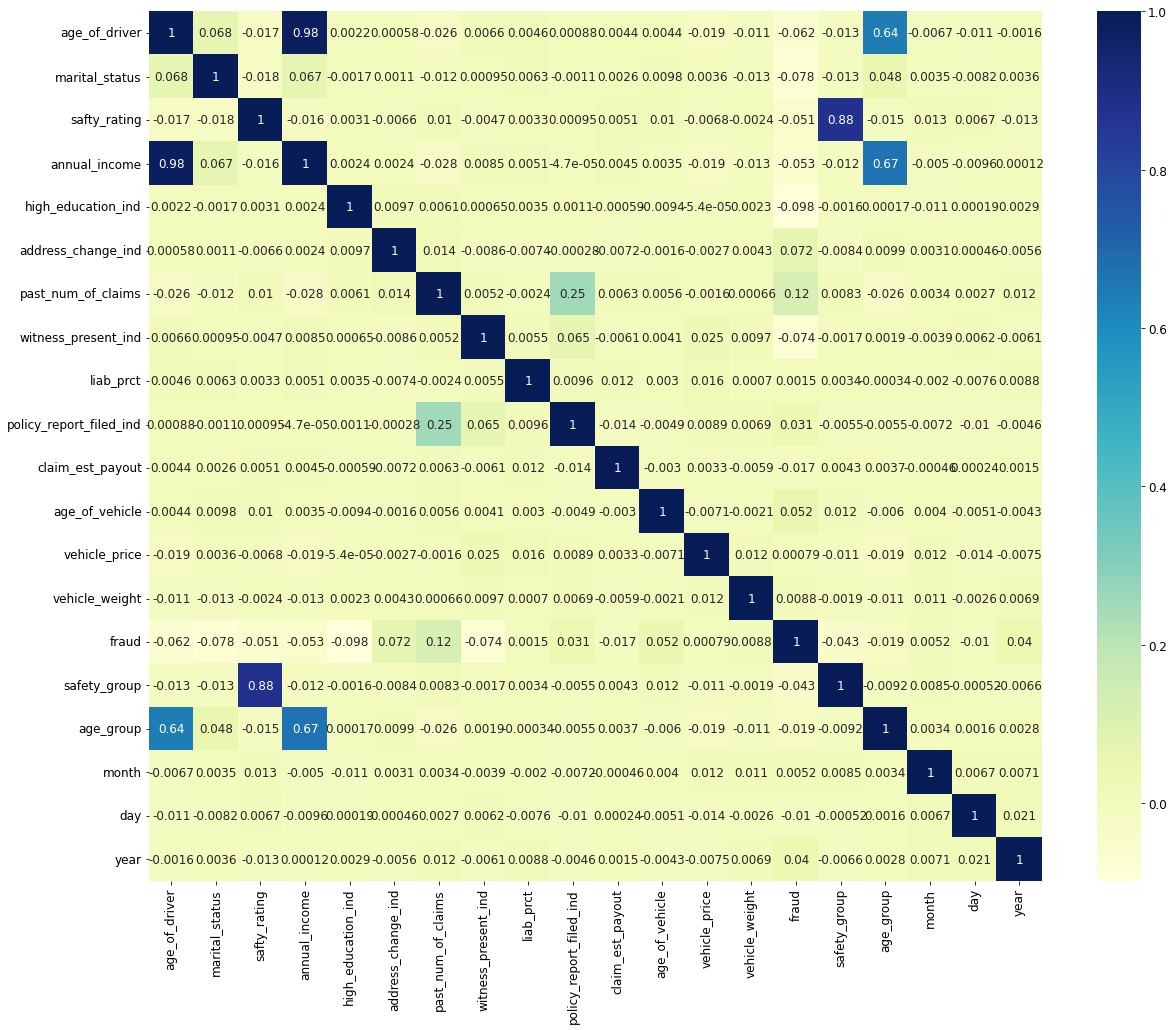

In [ ]:
#Check relationship between variables
plt.figure(figsize=(20,16))
sns.heatmap(df.corr(), cmap="YlGnBu", annot = True)
plt.show()

#Older = Higher income. Highly correlated, can just use one of them to avoid multicollinearity.
#Past number of claims correlated with policy report filed..
#Witness present correlated with policy report filed..
#Past number of claims correlated with fraud..

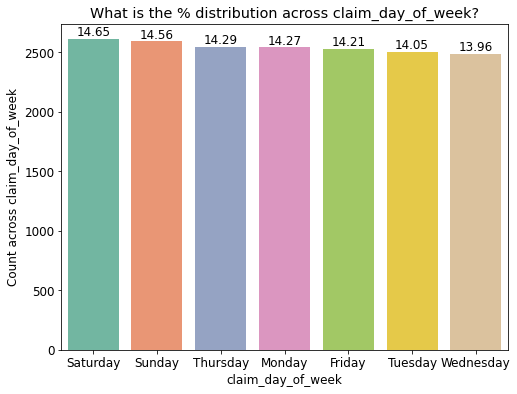

In [ ]:
bar_chart(df,'claim_day_of_week') #Likely a synthetic dataset since it's so evenly distributed. Tried with vehicle_color also. Nothing insightful.

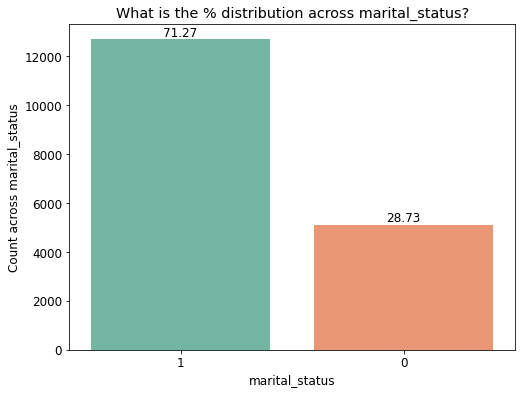

In [ ]:
bar_chart(df,'marital_status') #More married people. I guess makes sense because older and married people more likely to have a car due to higher income / family.

In [ ]:
# Grouping Safety into Safety Groups for Further Analysis/Visualisation
def getSafetyGroup(rating):
    if rating <= 50:
        return 0 #Low Safety Rating
    elif rating > 50 and rating < 80:
        return 1 #Medium Safety Rating
    else:
        return 2 #High Safety Rating

df['safety_group'] = df['safty_rating'].apply(getSafetyGroup)
df

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,claim_date,claim_day_of_week,...,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud,safety_group,age_group,month,day,year
0,46,M,1,85,38301,1,1,Rent,2016-12-16,Friday,...,Compact,12885.452350,white,16161.33381,0,2,1,12,16,2016
1,21,F,0,75,30445,0,1,Rent,2015-02-12,Thursday,...,Large,29429.452180,white,28691.96422,0,1,0,2,12,2015
2,49,F,0,87,38923,0,1,Own,2016-12-06,Tuesday,...,Compact,21701.181950,white,22090.94758,1,2,1,12,6,2016
3,58,F,1,58,40605,1,0,Own,2016-05-05,Thursday,...,Medium,13198.273440,other,38329.58106,1,1,1,5,5,2016
4,38,M,1,95,36380,1,0,Rent,2015-10-27,Tuesday,...,Medium,38060.211220,gray,25876.56319,0,2,1,10,27,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17993,69,M,1,93,42338,1,0,Own,2015-03-28,Saturday,...,Medium,32144.571850,black,16868.53410,0,2,2,3,28,2015
17994,35,F,0,22,35579,1,1,Own,2015-01-05,Monday,...,Medium,9468.510601,blue,31500.99689,1,0,1,1,5,2015
17995,27,F,1,81,32953,0,1,Rent,2016-09-10,Saturday,...,Medium,64974.369590,black,44536.25506,0,2,0,9,10,2016
17996,52,F,1,86,39519,1,0,Own,2015-12-25,Friday,...,Compact,24983.268110,white,50093.75959,0,2,1,12,25,2015


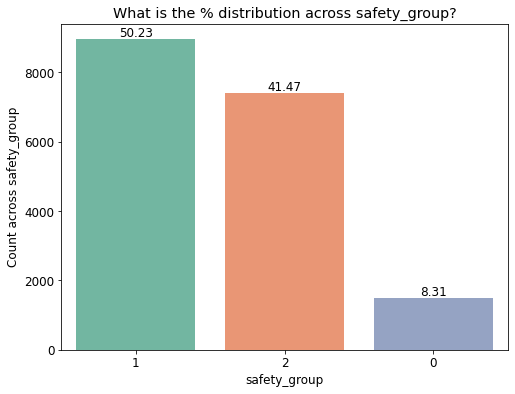

In [ ]:
bar_chart(df,'safety_group') 

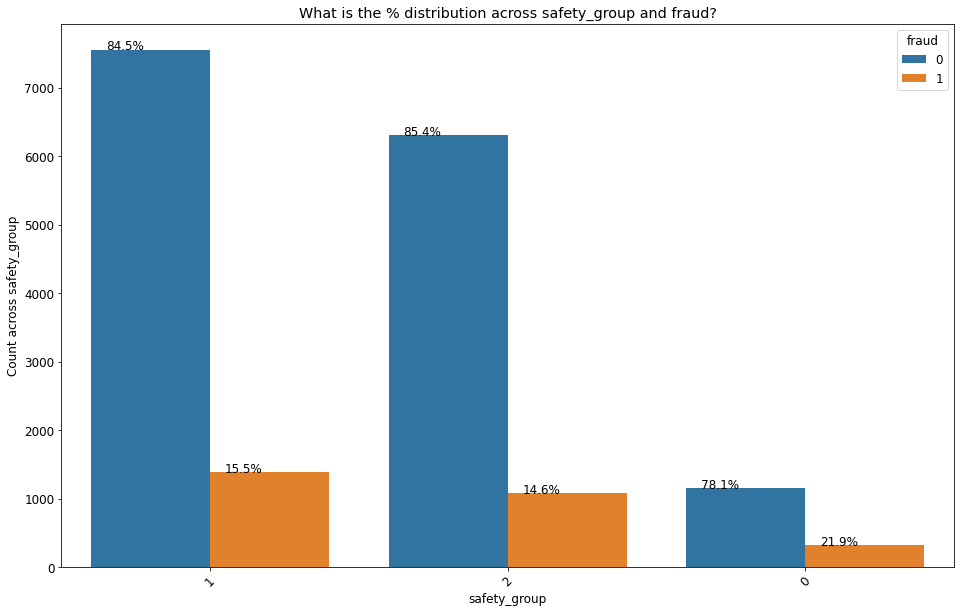

In [ ]:
bar_chart_hue(df,'safety_group','fraud',3,2)
#Low safety rating actually quite a small group, but a surprisingly high percentage of fraud comes from there. Could play a part in predicting fraud.

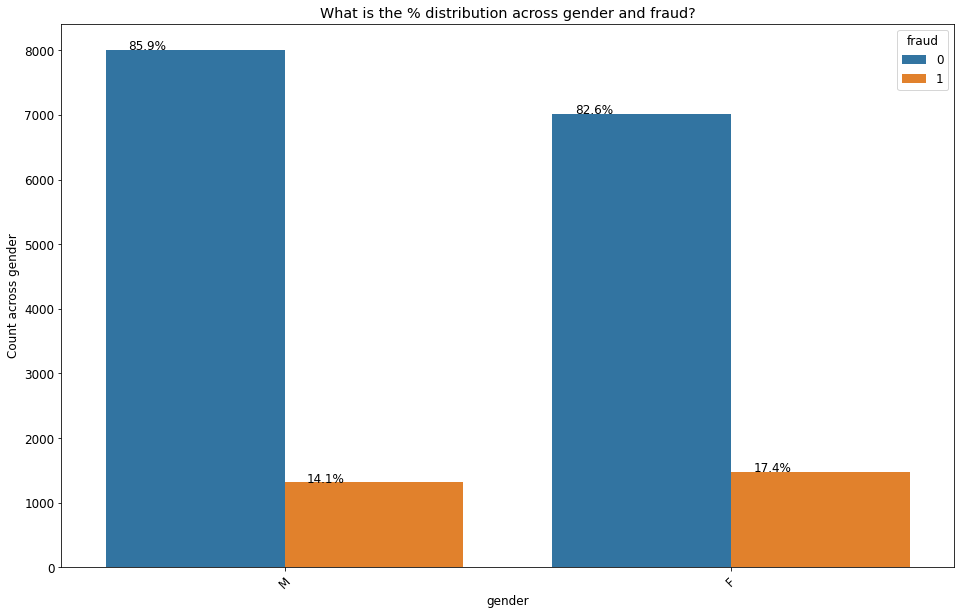

In [ ]:
bar_chart_hue(df,'gender','fraud',2,2) #females more likely to fraud?

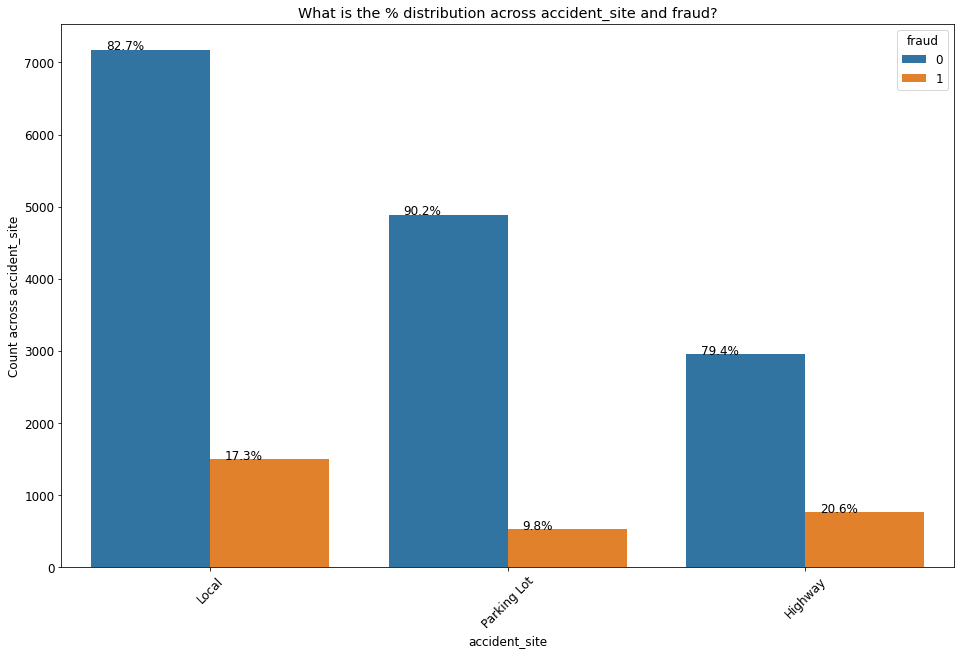

In [ ]:
bar_chart_hue(df,'accident_site','fraud',3,2) #Highway more likely to fraud?

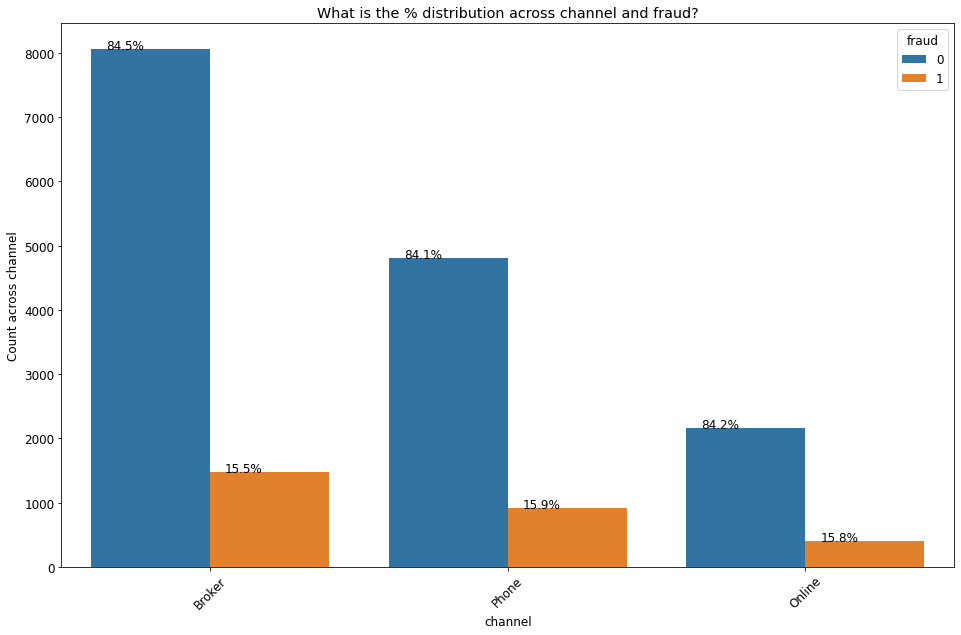

In [ ]:
bar_chart_hue(df,'channel','fraud',3,2) #nothing significant. same goes to vehicle_category.

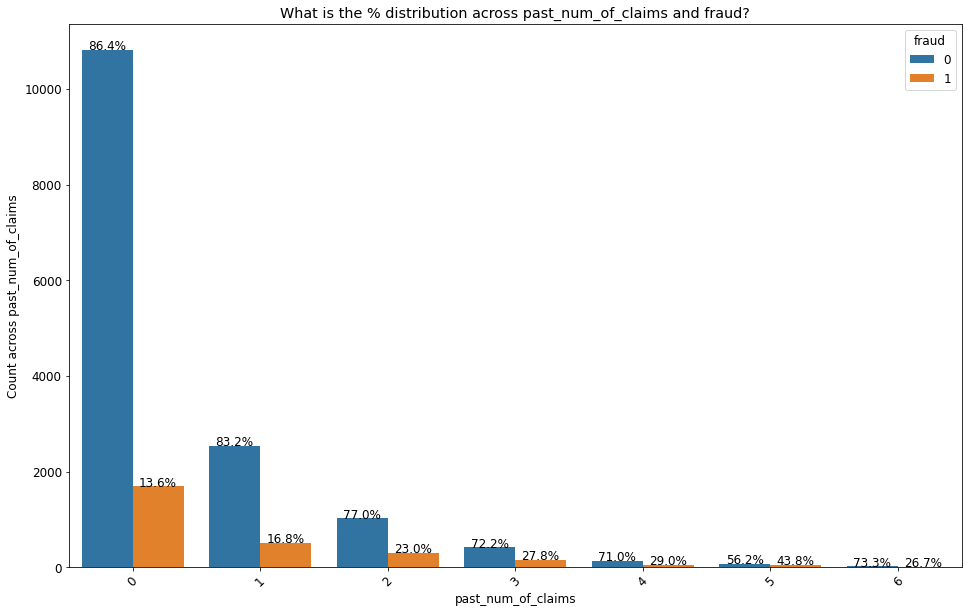

In [ ]:
bar_chart_hue(df,'past_num_of_claims','fraud',7,2) #If past number of claims is 5, 40% chance of fraud!!

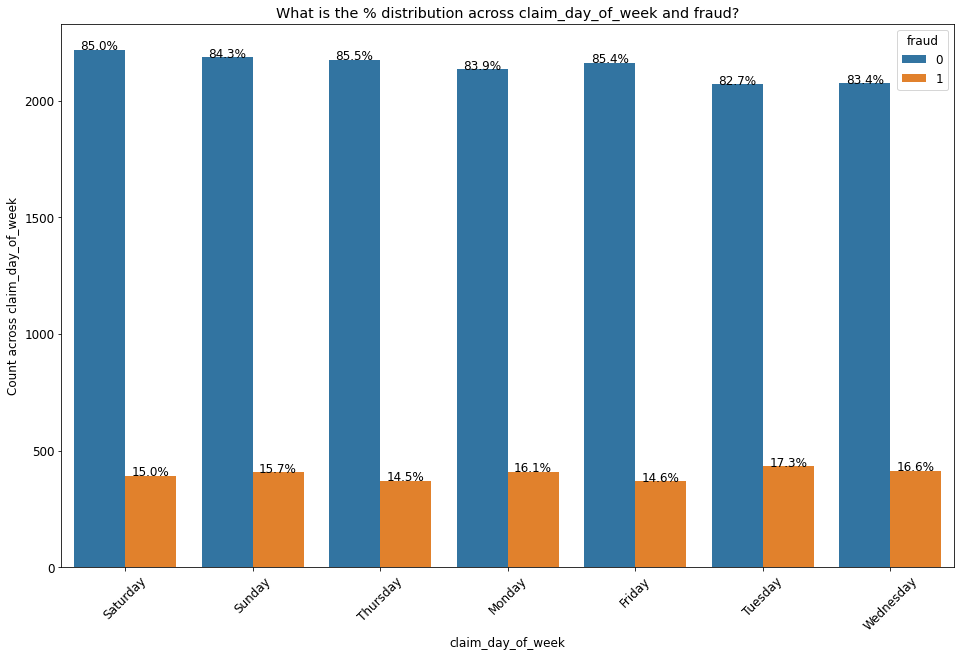

In [ ]:
bar_chart_hue(df,'claim_day_of_week','fraud',7,2) #Tuesday highest percentage, but also not very significant.

In [ ]:
# Grouping Age into Age Groups for Further Analysis/Visualisation
def getAgeGroup(age):
    if age <= 30:
        return 0 #Young Adults
    elif age > 31 and age < 65:
        return 1 #Middle Age Adults
    else:
        return 2 #Elderly

df['age_group'] = df['age_of_driver'].apply(getAgeGroup)

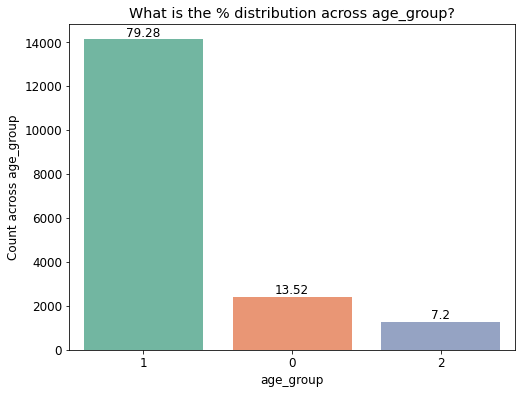

In [ ]:
bar_chart(df,'age_group') 

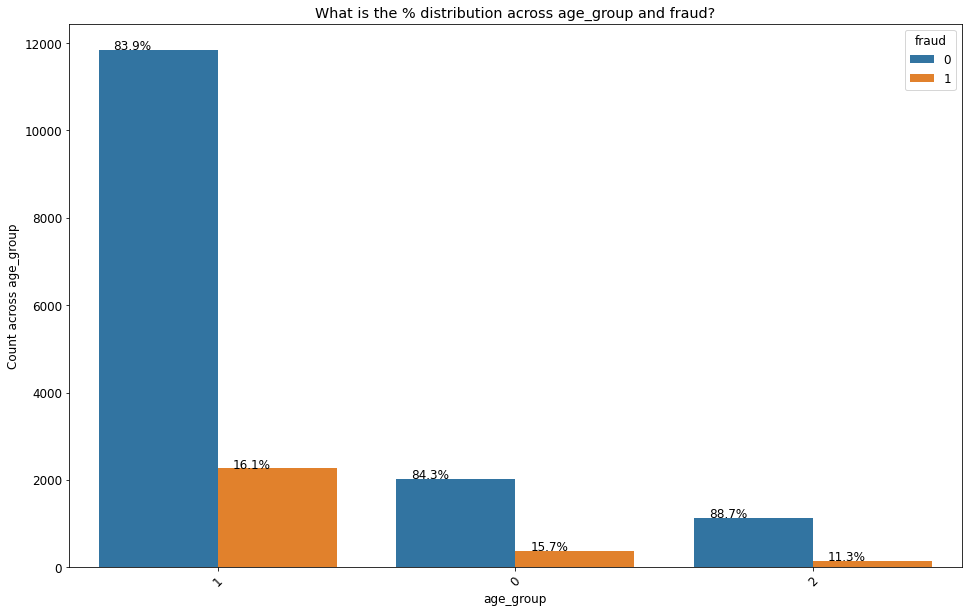

In [ ]:
bar_chart_hue(df,'age_group','fraud',3,2) #nothing significant. Most people come from age_group 1 (middle age) so naturally more fraud comes from there.

In [ ]:
fraud_only = df[df['fraud']==1]
not_fraud = df[df['fraud']==0]

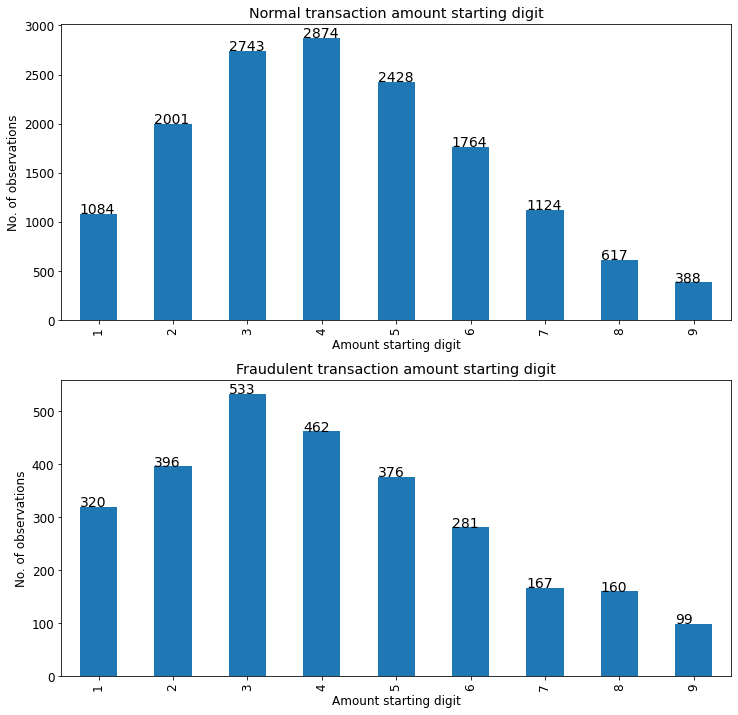

In [ ]:
# fraudulent transaction amount first digit
plt.subplots(2,1, figsize=(12,12))

# non-fraud transactions
plt.subplot(2,1,1)
ax=np.floor(not_fraud['claim_est_payout']).astype('str').str[0].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Amount starting digit')
plt.ylabel('No. of observations')
plt.title('Normal transaction amount starting digit')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)), fontsize=14, color='black')
    
# fraud transactions
plt.subplot(2,1,2)
ax=np.floor(fraud_only['claim_est_payout']).astype('str').str[0].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Amount starting digit')
plt.ylabel('No. of observations')
plt.title('Fraudulent transaction amount starting digit')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)), fontsize=14, color='black')

In [ ]:
#Converting date variable to month,day,year
df.claim_date = pd.to_datetime(df.claim_date,dayfirst=False)
df[['month']] = pd.DataFrame(df.claim_date.dt.month)
df[['day']] = pd.DataFrame(df.claim_date.dt.day)
df[['year']] = pd.DataFrame(df.claim_date.dt.year)

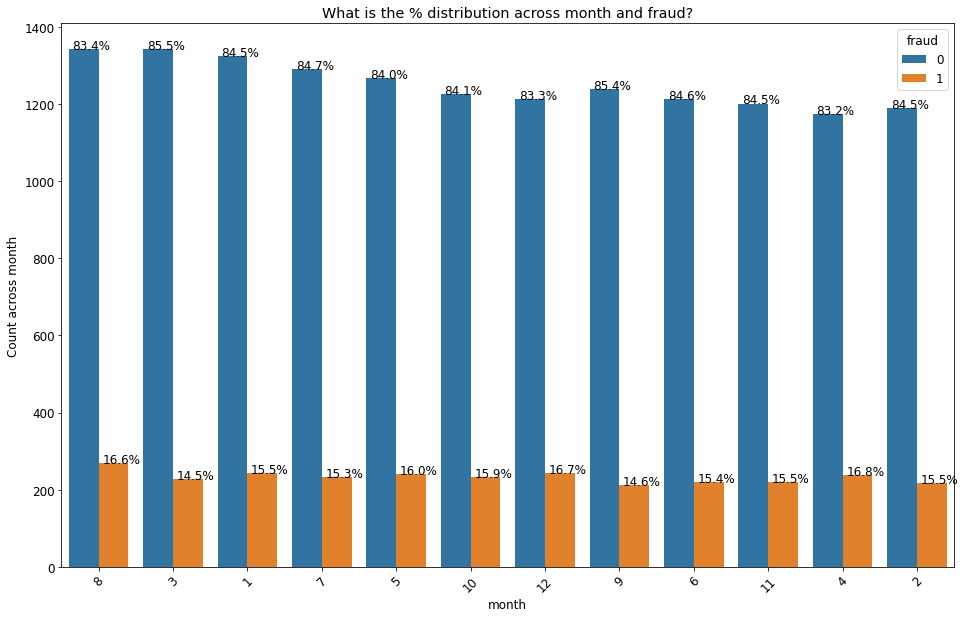

In [ ]:
bar_chart_hue(df,'month','fraud',12,2) #nothing significant on fraud and the month of claim.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fafdbeb6a50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fafdbe84cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fafdbeb6590>],
 'medians': [<matplotlib.lines.Line2D at 0x7fafdb331a10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fafdb2d6810>],
 'means': []}

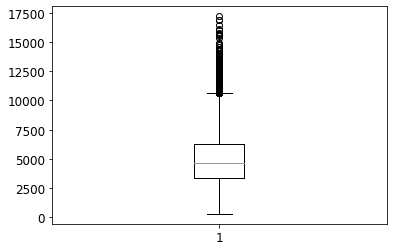

In [ ]:
plt.boxplot(df['claim_est_payout']) #Average is $5000. Between $2500 and $7500. Outliers > $10000.

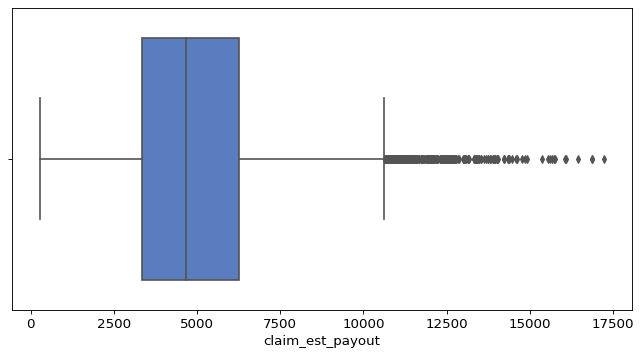

In [ ]:
plt.figure(figsize=(10,5), dpi= 80)
ax = sns.boxplot(x="claim_est_payout", 
                    data=df, palette="muted")
# The average was found to be around $5000, with most claims between $2500 to $7500. The outliers lie around the more than $10000 mark. 


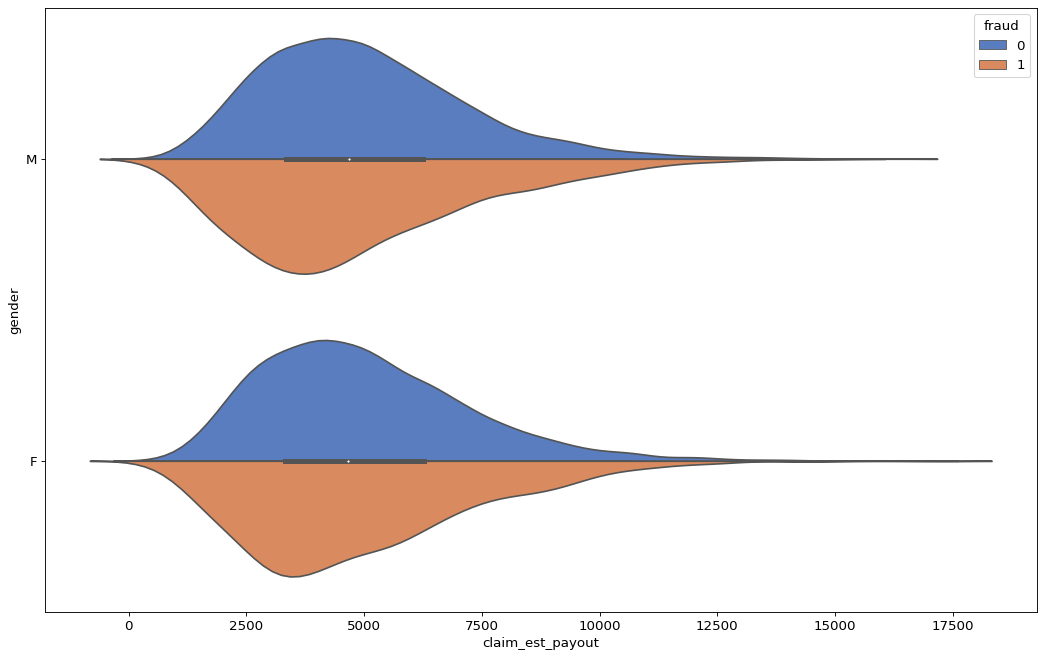

In [ ]:
plt.figure(figsize=(16,10), dpi= 80)
ax = sns.violinplot(x="claim_est_payout", y="gender", hue="fraud",
                    data=df, palette="muted", split = True)
#Plotting a distribution of the claim payouts based on gender and whether the claim is fraud, it was found that the distributions are quite similar regardless of whether the claim is fraud.

Text(0, 0.5, 'Frequency')

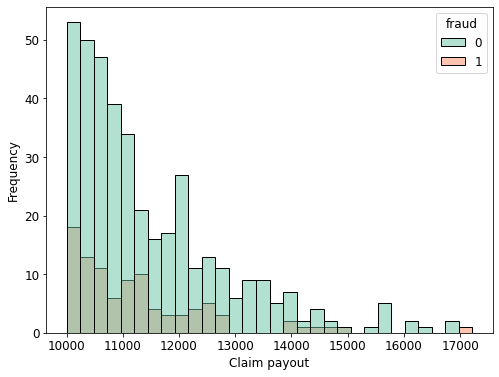

In [ ]:
#Zoom into high claims to see the fraud distribution
claim_outliers = df[df['claim_est_payout']>10000]
plt.figure(figsize=(8,6))
ax = sns.histplot(data=claim_outliers, x='claim_est_payout', hue='fraud', bins=30,palette="Set2")
ax.set_xlabel('Claim payout')
ax.set_ylabel(f'Frequency')

#$11500 and $17000 has quite high chance of fraud?

# Data Pre-processing

### Dropping columns


In [ ]:
# Split into features and target
# Dropped claim_date since its split into day/month/year. 
# Dropped safety_group and age_group which is created by ourselves for EDA purposes only. 
# Fraud is dropped as as its the target variable to predict
X_full = df.drop(columns = ["fraud", "claim_date","safety_group","age_group"]) 
y_full = df[["fraud"]]
X_full.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,claim_day_of_week,accident_site,...,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,month,day,year
0,46,M,1,85,38301,1,1,Rent,Friday,Local,...,0,7530.940993,9,Compact,12885.45235,white,16161.33381,12,16,2016
1,21,F,0,75,30445,0,1,Rent,Thursday,Highway,...,0,2966.024895,4,Large,29429.45218,white,28691.96422,2,12,2015
2,49,F,0,87,38923,0,1,Own,Tuesday,Local,...,0,6283.888333,3,Compact,21701.18195,white,22090.94758,12,6,2016
3,58,F,1,58,40605,1,0,Own,Thursday,Local,...,1,6169.747994,4,Medium,13198.27344,other,38329.58106,5,5,2016
4,38,M,1,95,36380,1,0,Rent,Tuesday,Highway,...,0,4541.387150,7,Medium,38060.21122,gray,25876.56319,10,27,2015


In [ ]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17817 entries, 0 to 17997
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_of_driver            17817 non-null  int64  
 1   gender                   17817 non-null  object 
 2   marital_status           17817 non-null  int64  
 3   safty_rating             17817 non-null  int64  
 4   annual_income            17817 non-null  int64  
 5   high_education_ind       17817 non-null  int64  
 6   address_change_ind       17817 non-null  int64  
 7   living_status            17817 non-null  object 
 8   claim_day_of_week        17817 non-null  object 
 9   accident_site            17817 non-null  object 
 10  past_num_of_claims       17817 non-null  int64  
 11  witness_present_ind      17817 non-null  int64  
 12  liab_prct                17817 non-null  int64  
 13  channel                  17817 non-null  object 
 14  policy_report_filed_in

### Categorical Variables Encoding



In [ ]:
categorize = ["gender","marital_status","living_status","claim_day_of_week","accident_site","channel","vehicle_category","vehicle_color"] 

# fitting OHE on the data 
ohe = OneHotEncoder(drop='first', sparse=False) # To prevent dummy variable trap drop one column from each cateogory use dropfirst
ohe.fit(X_full[categorize])

def get_ohe(df):
    temp_df = pd.DataFrame(data=ohe.transform(df[categorize]), columns=ohe.get_feature_names_out())
    df.drop(columns=categorize, axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    return df

# transforming OHE on the data
X_full = get_ohe(X_full)

### Train Test Split

In [ ]:
# Split data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=1, stratify=y_full)

### Data Standardisation / Normalisation

In [ ]:
# Must scale the numerical variables in features for standardisation and faster convergence during ML training
numerical_var = [
    'age_of_driver', 'safty_rating', 'annual_income',  'high_education_ind', 'address_change_ind', 'past_num_of_claims', 'witness_present_ind',
    'liab_prct', 'policy_report_filed_ind', 'claim_est_payout', 'age_of_vehicle', 'vehicle_price', 'vehicle_weight']

sc = StandardScaler()
X_train[numerical_var] = sc.fit_transform(X_train[numerical_var])
X_test[numerical_var] = sc.transform(X_test[numerical_var])

X_train.head()

,age_of_driver,safty_rating,annual_income,high_education_ind,address_change_ind,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,...,channel_Online,channel_Phone,vehicle_category_Large,vehicle_category_Medium,vehicle_color_blue,vehicle_color_gray,vehicle_color_other,vehicle_color_red,vehicle_color_silver,vehicle_color_white
8497,0.119678,-0.819427,0.253625,-1.520385,-1.158584,-0.527543,-0.553657,-0.042698,-1.220673,-0.194488,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9702,1.224400,0.029174,1.174602,0.657728,0.863122,-0.527543,1.806173,-1.082641,-1.220673,-0.855796,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
238,-0.475172,-0.297211,-0.365948,0.657728,-1.158584,0.515903,-0.553657,-1.350054,-1.220673,1.221072,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2561,0.119678,1.138883,0.253625,0.657728,-1.158584,4.689686,-0.553657,-0.636951,0.819220,0.657380,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3632,3.178908,0.681944,2.385685,0.657728,-1.158584,-0.527543,-0.553657,0.254428,0.819220,0.036345,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Feature Engineering

### K-Means Clustering

In [ ]:
# Varied the number of clusters to fit the training data 
km_list = []
for cluster_num in range(1, 31):
    km = KMeans(n_clusters=cluster_num, init='k-means++', random_state=1)
    km = km.fit(X_train[numerical_var])
    km_list.append(pd.Series({'clusters': cluster_num, 'inertia':km.inertia_, 'model':km}))

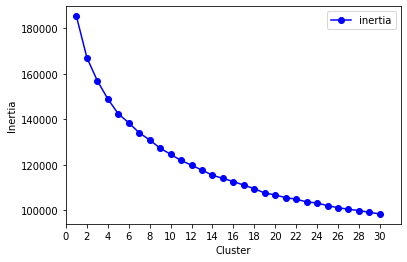

In [ ]:
# Use the elbow curve to determine the optimum number of clusters
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o', ls='-', color='blue')
ax.set_xticks(range(0, 32, 2))
ax.set_xlim(0,32)
ax.set(xlabel='Cluster', ylabel='Inertia');

In [ ]:
# Based on the elbow curve and considering the computation cost, we can choose any number of clusters between 10 to 15. 
# Set the number of clusters as 12 and fit the model.
kmeans = KMeans(n_clusters = 12, init='k-means++', random_state=1)
kmeans.fit(X_train[numerical_var])
km_pred = kmeans.predict(X_train[numerical_var])
X_train['km_cluster'] = km_pred

In [ ]:
X_train['km_cluster'].value_counts()

4     1754
3     1618
1     1592
7     1419
6     1331
9     1317
2     1035
11     967
8      867
10     860
0      750
5      743
Name: km_cluster, dtype: int64

In [ ]:
# Apply the kmeans model trained using trained data to formulate clusters for test set
test_km_pred = kmeans.predict(X_test[numerical_var])
X_test['km_cluster'] = test_km_pred
X_test.head()

,age_of_driver,safty_rating,annual_income,high_education_ind,address_change_ind,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,...,channel_Phone,vehicle_category_Large,vehicle_category_Medium,vehicle_color_blue,vehicle_color_gray,vehicle_color_other,vehicle_color_red,vehicle_color_silver,vehicle_color_white,km_cluster
8523,0.714529,0.290282,0.778804,-1.520385,0.863122,4.689686,-0.553657,0.016727,0.819220,0.479007,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11
198,0.119678,-0.231934,0.247065,-1.520385,0.863122,-0.527543,-0.553657,1.324084,-1.220673,-1.055674,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,9
829,0.289636,-0.036103,0.413256,0.657728,-1.158584,1.559349,-0.553657,-1.468905,0.819220,-0.651605,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11
12244,0.544571,-0.558319,0.637031,0.657728,-1.158584,0.515903,-0.553657,-1.468905,0.819220,0.366132,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3
11623,0.629550,-1.602751,0.701175,-1.520385,0.863122,-0.527543,1.806173,-1.468905,-1.220673,1.862625,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10


### Agglomerative Clustering

In [ ]:
ag_model = AgglomerativeClustering(n_clusters=12, linkage='ward', compute_full_tree=True).fit(X_train[numerical_var])
ag_pred = ag_model.fit_predict(X_train[numerical_var])
X_train['ag_cluster'] = ag_pred
X_train.head()

,age_of_driver,safty_rating,annual_income,high_education_ind,address_change_ind,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,...,vehicle_category_Large,vehicle_category_Medium,vehicle_color_blue,vehicle_color_gray,vehicle_color_other,vehicle_color_red,vehicle_color_silver,vehicle_color_white,km_cluster,ag_cluster
8497,0.119678,-0.819427,0.253625,-1.520385,-1.158584,-0.527543,-0.553657,-0.042698,-1.220673,-0.194488,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,9,3
9702,1.224400,0.029174,1.174602,0.657728,0.863122,-0.527543,1.806173,-1.082641,-1.220673,-0.855796,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0
238,-0.475172,-0.297211,-0.365948,0.657728,-1.158584,0.515903,-0.553657,-1.350054,-1.220673,1.221072,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4,2
2561,0.119678,1.138883,0.253625,0.657728,-1.158584,4.689686,-0.553657,-0.636951,0.819220,0.657380,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,11,5
3632,3.178908,0.681944,2.385685,0.657728,-1.158584,-0.527543,-0.553657,0.254428,0.819220,0.036345,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1


In [ ]:
# Apply the Agglomerative model trained using trained data to formulate clusters for test set
test_ag_pred = ag_model.fit_predict(X_test[numerical_var])
X_test['ag_cluster'] = test_ag_pred
X_test.head()

,age_of_driver,safty_rating,annual_income,high_education_ind,address_change_ind,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,...,vehicle_category_Large,vehicle_category_Medium,vehicle_color_blue,vehicle_color_gray,vehicle_color_other,vehicle_color_red,vehicle_color_silver,vehicle_color_white,km_cluster,ag_cluster
8523,0.714529,0.290282,0.778804,-1.520385,0.863122,4.689686,-0.553657,0.016727,0.819220,0.479007,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11,9
198,0.119678,-0.231934,0.247065,-1.520385,0.863122,-0.527543,-0.553657,1.324084,-1.220673,-1.055674,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,9,0
829,0.289636,-0.036103,0.413256,0.657728,-1.158584,1.559349,-0.553657,-1.468905,0.819220,-0.651605,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11,9
12244,0.544571,-0.558319,0.637031,0.657728,-1.158584,0.515903,-0.553657,-1.468905,0.819220,0.366132,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3,5
11623,0.629550,-1.602751,0.701175,-1.520385,0.863122,-0.527543,1.806173,-1.468905,-1.220673,1.862625,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10,6


# Feature Selection 

In [ ]:
# Mutual Information Support method for feature selection 
np.random.seed(2)
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
fit = bestfeatures.fit(X_train,y_train,)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
mutual_info_support = bestfeatures.get_support()
print(featureScores.nlargest(10,'Score')) 

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


                      Feature     Score
0               age_of_driver  0.013750
38                 ag_cluster  0.012520
37                 km_cluster  0.011696
3          high_education_ind  0.007934
26  accident_site_Parking Lot  0.007040
33        vehicle_color_other  0.006292
2               annual_income  0.005547
5          past_num_of_claims  0.005320
16                   gender_M  0.004753
15                       year  0.004575


In [ ]:
# Lasso method for feature selection 
np.random.seed(2)
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2", max_iter = 1000), max_features=10)
embeded_lr_selector.fit(X_train, y_train.values.ravel())

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')
print(embeded_lr_feature)

10 selected features
['age_of_driver', 'high_education_ind', 'address_change_ind', 'past_num_of_claims', 'witness_present_ind', 'age_of_vehicle', 'gender_M', 'marital_status_1', 'accident_site_Parking Lot', 'channel_Online']


In [ ]:
# RFE
np.random.seed(2)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(max_iter = 1000), n_features_to_select=10, step=10, verbose=5)
rfe_selector.fit(X_train, y_train.values.ravel())
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 39 features.
Fitting estimator with 29 features.
Fitting estimator with 19 features.
10 selected features
['age_of_driver', 'annual_income', 'high_education_ind', 'address_change_ind', 'past_num_of_claims', 'witness_present_ind', 'gender_M', 'marital_status_1', 'accident_site_Local', 'accident_site_Parking Lot']


In [ ]:
# Tree based 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state = 1), max_features=10)
embeded_rf_selector.fit(X_train, y_train.values.ravel())

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_rf_feature)

10 selected features
['age_of_driver', 'safty_rating', 'annual_income', 'liab_prct', 'claim_est_payout', 'age_of_vehicle', 'vehicle_price', 'vehicle_weight', 'month', 'day']


In [ ]:
feature_name = X_train.columns.tolist()
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'mutual_info': mutual_info_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
# feature_selection_df.head()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [ ]:
feature_selection_df[feature_selection_df['Total'] > 0]

,Feature,RFE,Logistics,Random Forest,mutual_info,Total
1,age_of_driver,True,True,True,True,4
2,past_num_of_claims,True,True,False,True,3
3,high_education_ind,True,True,False,True,3
4,gender_M,True,True,False,True,3
5,annual_income,True,False,True,True,3
6,accident_site_Parking Lot,True,True,False,True,3
7,witness_present_ind,True,True,False,False,2
8,marital_status_1,True,True,False,False,2
9,age_of_vehicle,False,True,True,False,2
10,address_change_ind,True,True,False,False,2


In [ ]:
x_columns = feature_selection_df[feature_selection_df['Total'] > 1]['Feature'].tolist()
x_columns

['age_of_driver',
 'past_num_of_claims',
 'high_education_ind',
 'gender_M',
 'annual_income',
 'accident_site_Parking Lot',
 'witness_present_ind',
 'marital_status_1',
 'age_of_vehicle',
 'address_change_ind']

In [ ]:
# Final list of features to be used in subsequent model training, dropped annual income due to high correlation with age of driver
x_columns = ['age_of_driver', 'past_num_of_claims', 'marital_status_1', 'high_education_ind', 'accident_site_Parking Lot', 
             'witness_present_ind', 'gender_M', 'age_of_vehicle', 'address_change_ind']

# Modelling

### Common Functions for Cross Validation & Model Performance Evaluation

In [ ]:
def evaluate_results(y_test, y_pred, print_result=True):
    '''
    This is a helper function that we will call to print basic results statistics.
    '''
    # Create confusion matrix of validation data
    perf_metric = dict()
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()

    # Evaluation Statistics
    # Performance of decision tree model on validation data
    perf_metric["Accuracy"] = accuracy_score(y_test, y_pred)
    perf_metric["Recall"] = recall_score(y_test, y_pred)
    perf_metric["Precision"] = precision_score(y_test, y_pred)
    perf_metric["F1"] = f1_score(y_test, y_pred)
    perf_metric["MCC"] = matthews_corrcoef(y_test, y_pred)
    perf_metric["F1_macro"] = f1_score(y_test, y_pred, average = "macro")
    perf_metric["ROC_AUC"] = roc_auc_score(y_test, y_pred)

    if print_result:
      # Print confusion matrix
      print("Confusion Matrix: \n", cm)
      print("TN: %s, FP: %s, FN: %s, TP: %s" %(TN, FP, FN, TP))
      print("\n")
      # Print evluation metrics
      for metric, val in perf_metric.items():
        print("{}: {}".format(metric, val))
      print("\n")
      print("\n")
    return perf_metric

In [ ]:
kf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

def evaluate_model(selected_model, sampling_method, x_var_list, evaluate_f1=False, print_result=True):
  x_var = x_var_list
  y_var = 'fraud'
  all_y_preds = [] # predictions
  all_y_true = [] # true labels

  for train_index, test_index in kf.split(X_train[x_var], y_train[y_var]):
    X_train_set, X_test_set = X_train.iloc[train_index][x_var], X_train.iloc[test_index][x_var]
    y_train_set, y_test_set = y_train.iloc[train_index][y_var], y_train.iloc[test_index][y_var]

    # Assign the classifier here
    model = selected_model

    # SMOTE oversampling
    if sampling_method == "SMOTE":
      smote_only = SMOTE(random_state=1, sampling_strategy=0.5)
      X_res_smote, y_res_smote = smote_only.fit_resample(X_train_set, y_train_set)
      model.fit(X_res_smote, y_res_smote)

    # Hybrid of SMOTE and ENN
    elif sampling_method == "SMOTE_ENN":
      ennObj = EditedNearestNeighbours(n_neighbors=5)
      smote_only = SMOTE(random_state=1, sampling_strategy=0.5)
      smote_enn = SMOTEENN(smote=smote_only, enn= ennObj)
      X_res_smoteENN, y_res_smoteENN = smote_enn.fit_resample(X_train_set, y_train_set)
      model.fit(X_res_smoteENN, y_res_smoteENN)

    else:
      model.fit(X_train_set, y_train_set)

    y_preds = model.predict(X_test_set)
    all_y_preds.extend(y_preds)
    all_y_true.extend(y_test_set)  
  
  if evaluate_f1:
    return(f1_score(all_y_true, all_y_preds))
  else:
    return evaluate_results(all_y_true, all_y_preds, print_result)

### Common Functions for Model Tuning via Bayesian Optimisation

In [ ]:
# Helper function for Bayesian hyperparameter optimisation
def hyperopt(param_space, num_eval, classifier, sampling_method, x_var_list):  
    start = time.time()
    def objective_function(params):
        clf = classifier(**params)
        
        score = evaluate_model(clf, sampling_method, x_var_list, evaluate_f1=True)
        return {'loss': -score, 'status': STATUS_OK}
    trials = Trials()
    best_param = fmin(objective_function, param_space, algo=tpe.suggest, max_evals=num_eval, 
                      trials=trials, rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials] 
    best_param_values = best_param
    return trials, best_param_values

In [ ]:
# Helper functions to save tuning results if required.
if not os.path.exists('Tuning'): os.mkdir('Tuning')
    
def save_file(path, data):
    output = open(path, 'wb')
    pickle.dump(data, output)
    output.close()

def load_file(path):
    pkl_file = open(path, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

# Function to load models and identify best model with minimum loss
def load_model(parameters, num_eval, sampling_method, classifier, x_var_list, file_name, load):
  if(load == False):
      model_hyperopt = hyperopt(parameters, num_eval, classifier, sampling_method, x_var_list)
      save_file(file_name, model_hyperopt)
  else:
      try:
          model_hyperopt = load_file(file_name)
      except Exception as e:
          print(e)
  return model_hyperopt

In [ ]:
# Function to get the parameter set and loss from the tuning result
def show_tuning_result(model_hyperopt):
  trials = model_hyperopt[0].trials
  import json

  record = []
  losses = []
  for trial in trials:
    # get the loss and hyperparameter values from each trial
    loss = trial["result"]["loss"]
    values = trial["misc"]['vals']
    losses.append(loss)
    record.append(values)

  bayesTrialsData = pd.DataFrame(record)

  bayesTrialsData.insert(0, 'loss', losses)
  return bayesTrialsData

## Logistic Regression 

In [ ]:
print("LogReg - No Sampling \n")
no_sampling_perf_logreg1 = evaluate_model(LogisticRegression(solver='liblinear'), "None", x_columns, evaluate_f1=False, print_result=True)
no_sampling_perf_logreg1['Model'] = "No Sampling LogReg"

print("LogReg - SMOTE_ENN sampling \n")
no_sampling_perf_logreg2 = evaluate_model(LogisticRegression(solver='liblinear'), "SMOTE_ENN", x_columns, evaluate_f1=False, print_result=True)
no_sampling_perf_logreg2['Model'] = "SMOTE ENN Sampling LogReg"

print("LogReg - SMOTE sampling \n")
no_sampling_perf_logreg3 = evaluate_model(LogisticRegression(solver='liblinear'), "SMOTE", x_columns, evaluate_f1=False, print_result=True)
no_sampling_perf_logreg3['Model'] = "SMOTE Sampling LogReg"

print("LogReg - Class Weight = balanced \n")
no_sampling_perf_logreg4 = evaluate_model(LogisticRegression(solver='liblinear', class_weight='balanced'), "None", x_columns, evaluate_f1=False, print_result=True)
no_sampling_perf_logreg4['Model'] = "Class Weighted LogReg"

LogReg - No Sampling 

Confusion Matrix: 
 [[11960    58]
 [ 2184    51]]
TN: 11960, FP: 58, FN: 2184, TP: 51


Accuracy: 0.8426997825019295
Recall: 0.022818791946308724
Precision: 0.46788990825688076
F1: 0.043515358361774746
MCC: 0.07510204717236893
F1_macro: 0.4789092730957257
ROC_AUC: 0.5089963488771317




LogReg - SMOTE_ENN sampling 

Confusion Matrix: 
 [[6253 5765]
 [ 559 1676]]
TN: 6253, FP: 5765, FN: 559, TP: 1676


Accuracy: 0.5563039360134708
Recall: 0.7498881431767338
Precision: 0.22523854320655826
F1: 0.34642414220752377
MCC: 0.19668570916849062
F1_macro: 0.5052885448159233
ROC_AUC: 0.6350955110957724




LogReg - SMOTE sampling 

Confusion Matrix: 
 [[10790  1228]
 [ 1630   605]]
TN: 10790, FP: 1228, FN: 1630, TP: 605


Accuracy: 0.7994808110573213
Recall: 0.27069351230425054
Precision: 0.33006001091107473
F1: 0.2974434611602753
MCC: 0.18304058740139753
F1_macro: 0.5902472236646781
ROC_AUC: 0.5842567245328876




LogReg - Class Weight = balanced 

Confusion Matrix: 
 [[76

In [ ]:
perf_summary_lr = [no_sampling_perf_logreg1, no_sampling_perf_logreg2, no_sampling_perf_logreg3, no_sampling_perf_logreg4]
perf_summary_lr_df = pd.DataFrame.from_dict(perf_summary_lr, orient='columns')
perf_summary_lr_df = perf_summary_lr_df.sort_values(['F1'] , ascending=False)
perf_summary_lr_df

,Accuracy,Recall,Precision,F1,MCC,F1_macro,ROC_AUC,Model
3,0.635726,0.634899,0.244866,0.353425,0.200451,0.549930,0.635389,Class Weighted LogReg
1,0.556304,0.749888,0.225239,0.346424,0.196686,0.505289,0.635096,SMOTE ENN Sampling LogReg
2,0.799481,0.270694,0.330060,0.297443,0.183041,0.590247,0.584257,SMOTE Sampling LogReg
0,0.842700,0.022819,0.467890,0.043515,0.075102,0.478909,0.508996,No Sampling LogReg


Gridsearch to optimize hyperparameters for logreg - we use gridsearch here as there are not that many hyperparameters for logreg, gridsearch won't take a very long time

In [ ]:
for train_index, test_index in kf.split(X_train[x_columns], y_train['fraud']):
    X_train_set, X_test_set = X_train.iloc[train_index][x_columns], X_train.iloc[test_index][x_columns]
    y_train_set, y_test_set = y_train.iloc[train_index]['fraud'], y_train.iloc[test_index]['fraud']

In [ ]:
ennObj = EditedNearestNeighbours(n_neighbors=5)
smote_only = SMOTE(random_state=1, sampling_strategy=0.5)
smote_enn = SMOTEENN(smote=smote_only, enn= ennObj)
X_res_smoteENN, y_res_smoteENN = smote_enn.fit_resample(X_train_set, y_train_set)

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# define dataset

# define models and parameters
model = LogisticRegression(class_weight= "balanced")
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2'] # l1 was used then removed to cut down on errors, best result still remained the same
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train_set, y_train_set)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.357493 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.357326 (0.018858) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.357326 (0.018858) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.357326 (0.018858) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.357326 (0.018858) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.357326 (0.018858) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.357326 (0.018858) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.357401 (0.018757) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.357401 (0.018757) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.357420 (0.018770) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.357135 (0.017986) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.357135 (0.017986) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.356859 (0.017578) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.357493 (0.016896) wi

Not much room for hyperparameter tuning, the different solvers and different c 
values all give very similar best f1, but we will use the best one recommended

In [ ]:
print("LogReg - Final Model \n")
final_logreg_model = LogisticRegression(solver='newton-cg', class_weight='balanced', penalty= 'l2', C = 0.01)
final_logreg_model_results = evaluate_model(final_logreg_model, "none", x_columns)

LogReg - Final Model 

Confusion Matrix: 
 [[7713 4305]
 [ 819 1416]]
TN: 7713, FP: 4305, FN: 819, TP: 1416


Accuracy: 0.6404967375289413
Recall: 0.6335570469798658
Precision: 0.24750917671735712
F1: 0.3559577677224736
MCC: 0.20425357227664928
F1_macro: 0.5533073510145216
ROC_AUC: 0.6376721830006669






In [ ]:
def model_test_data_perf(selected_model, sampling_method, x_var_list):
  # define empty lists to store results
  all_y_preds = [] # predictions
  all_y_true = [] # true labels
    
  # predict on validation set
  y_preds = selected_model.predict(X_test[x_var_list])
  all_y_preds.extend(y_preds)
  all_y_true.extend(y_test["fraud"])

  # Evaluate results
  evaluate_results(all_y_true, all_y_preds)

In [ ]:
model_test_data_perf(final_logreg_model, "None", x_columns)

Confusion Matrix: 
 [[1886 1119]
 [ 210  349]]
TN: 1886, FP: 1119, FN: 210, TP: 349


Accuracy: 0.627104377104377
Recall: 0.6243291592128801
Precision: 0.23773841961852862
F1: 0.3443512580167736
MCC: 0.18615876042267196
F1_macro: 0.5419070542191298
ROC_AUC: 0.6259748957462071






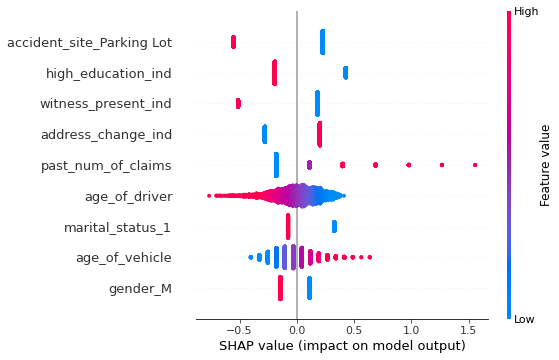

In [ ]:
masker = shap.maskers.Independent(data = X_train_set)
explainer = shap.LinearExplainer(final_logreg_model, masker = masker)
shap_values = explainer.shap_values(X_test[x_columns])
shap.summary_plot(shap_values, X_test[x_columns])

## XGBoost  

In [ ]:
# Use the default XGBoost classifier to determine which sampling method gives the best performance result
XG_model = XGBClassifier(random_state=1)

# 1. Default XGBoost without sampling method
print("XGBoost - No Sampling \n")
no_sampling_perf = evaluate_model(XG_model, "None", x_columns, evaluate_f1=False)
no_sampling_perf["Model"] = "No Sampling XGB"

# 2. Default XGBoost with SMOTE sampling method
print("XGBoost - With SMOTE Sampling Method \n")
smote_sampling_perf = evaluate_model(XG_model, "SMOTE", x_columns, evaluate_f1=False)
smote_sampling_perf["Model"] = "SMOTE Sampling XGB"

# 3. Default XGBoost with SMOTE_ENN sampling method
print("XGBoost - With SMOTE_ENN Sampling Method \n")
smote_enn_sampling_perf = evaluate_model(XG_model, "SMOTE_ENN", x_columns, evaluate_f1=False)
smote_enn_sampling_perf["Model"] = "SMOTE_ENN Sampling XGB"

# 4. Default XGBoost with inbuilt class weighting
print("XGBoost - With Inbuilt Class Weighting Method \n")
XG_model = XGBClassifier(random_state=1, scale_pos_weight=5)
class_weighted_sampling_perf = evaluate_model(XG_model, "None", x_columns, evaluate_f1=False)
class_weighted_sampling_perf["Model"] = "Class Weighting Sampling XGB"

XGBoost - No Sampling 

Confusion Matrix: 
 [[11971    47]
 [ 2174    61]]
TN: 11971, FP: 47, FN: 2174, TP: 61


Accuracy: 0.8441731565284502
Recall: 0.027293064876957495
Precision: 0.5648148148148148
F1: 0.052069995731967564
MCC: 0.0980455929214482
F1_macro: 0.4835895596517117
ROC_AUC: 0.511691132205495




XGBoost - With SMOTE Sampling Method 

Confusion Matrix: 
 [[11675   343]
 [ 1992   243]]
TN: 11675, FP: 343, FN: 1992, TP: 243


Accuracy: 0.8361748403844804
Recall: 0.1087248322147651
Precision: 0.41467576791808874
F1: 0.17227933356965616
MCC: 0.1468448949518105
F1_macro: 0.5406851213302826
ROC_AUC: 0.5400921548326281




XGBoost - With SMOTE_ENN Sampling Method 

Confusion Matrix: 
 [[7014 5004]
 [ 661 1574]]
TN: 7014, FP: 5004, FN: 661, TP: 1574


Accuracy: 0.6025398161790501
Recall: 0.7042505592841163
Precision: 0.23928245667376102
F1: 0.3571995915125383
MCC: 0.20997755411342595
F1_macro: 0.5347669617543395
ROC_AUC: 0.6439375612196917




XGBoost - With Inbuilt Class Weighting

In [ ]:
perf_summary = [no_sampling_perf, smote_sampling_perf, smote_enn_sampling_perf, class_weighted_sampling_perf]
perf_summary_df = pd.DataFrame.from_dict(perf_summary, orient='columns')
perf_summary_df = perf_summary_df.sort_values(['F1'] , ascending=False)
perf_summary_df

,Accuracy,Recall,Precision,F1,MCC,F1_macro,ROC_AUC,Model
3,0.659089,0.638031,0.260409,0.369861,0.225045,0.568100,0.650518,Class Weighting Sampling XGB
2,0.602540,0.704251,0.239282,0.357200,0.209978,0.534767,0.643938,SMOTE_ENN Sampling XGB
1,0.836175,0.108725,0.414676,0.172279,0.146845,0.540685,0.540092,SMOTE Sampling XGB
0,0.844173,0.027293,0.564815,0.052070,0.098046,0.483590,0.511691,No Sampling XGB


### XGBoost Model Hyperparameters Tuning
Based on above application, the default XGBoost with class weighting sample gives the highest F1 score. Therefore will use class weighting XGBoost for subsequent tuning process.

In [ ]:
# First Round of Tuning
XGB_param_hyperopt = {
    'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 18, 1)),
    'subsample': hp.uniform('subsample', 0.1, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 0.9),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 0.9),
    'gamma': hp.uniform('gamma', 1, 20),
    'min_child_weight': hp.uniform('min_child_weight', 1, 5),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 400, 20)), 
    'reg_lambda': hp.uniform('reg_lambda', 1, 5),
    'reg_alpha':hp.uniform('reg_alpha', 0.01, 0.1),
    'scale_pos_weight':hp.uniform('scale_pos_weight', 1, 6) # Include the class weighting sampling
}

XGB_hyperopt_weighting = load_model(XGB_param_hyperopt, 50, "None", XGBClassifier, x_columns, 'Tuning/XGB_hyperopt_weighting.pkl', False) # change to True if load model directly from the Tuning folder
weighting_XG_result = show_tuning_result(XGB_hyperopt_weighting)
weighting_XG_result.sort_values(by='loss')[:10]

100%|██████████| 50/50 [04:20<00:00,  5.22s/it, best loss: -0.372431397574984]


,loss,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,scale_pos_weight,subsample
31,-0.372431,[0.8736408771616087],[0.3772462672132999],[0.3529952529547359],[10.22604480115968],[0.22537849193064366],[2.0],[2.562991085565079],[300.0],[0.08161551385155381],[2.8037164712892952],[5.154565485063345],[0.4934430665455226]
37,-0.372105,[0.8489455574633873],[0.2524554665945067],[0.20857147515423227],[13.77648839932315],[0.323306810942869],[5.0],[3.109672095998691],[300.0],[0.06607070577924576],[2.1542234470414354],[5.136471455241099],[0.4501507649398159]
33,-0.371881,[0.8252089692495204],[0.10103128464958494],[0.210989766042786],[10.904874615763587],[0.3189863905835827],[6.0],[1.6757507354744603],[300.0],[0.07576243948960631],[2.7103532924056446],[4.932834276322587],[0.4698935926142797]
28,-0.370205,[0.26643621055243605],[0.5136109248539312],[0.43986379713887974],[15.796521306402301],[0.1674953728326231],[6.0],[2.616814439441386],[340.0],[0.08372870077527514],[3.159792670202782],[4.892449724004863],[0.3345041624387886]
39,-0.369741,[0.5300954355280165],[0.1642247226785872],[0.39388134912029615],[8.758092423734439],[0.26736098699883654],[1.0],[3.0970320225868364],[380.0],[0.06537282520704725],[2.0286702120994073],[4.604159185953831],[0.4508743776490356]
38,-0.369466,[0.85590089695103],[0.2622096240460546],[0.15099100374312996],[13.684488318259001],[0.3493589445466091],[4.0],[3.9192794600833833],[260.0],[0.05328040116675827],[2.23126364123202],[5.163059551703605],[0.49967017414889175]
12,-0.368415,[0.8971833123200937],[0.5388750345011247],[0.5479483076060213],[1.3212676313224598],[0.2035073715245996],[3.0],[2.583837177995842],[80.0],[0.010289397942893722],[1.282687493130609],[5.338893870586423],[0.41788154006066625]
36,-0.368365,[0.7282198945178796],[0.2792908772159718],[0.31083663919295834],[10.873279381685313],[0.3268704652818853],[2.0],[1.6496593469037615],[400.0],[0.05431435546221771],[1.544286015406101],[4.282988225461855],[0.4783046439846657]
45,-0.368179,[0.784375943350965],[0.31177571439224105],[0.49212084932526207],[12.563997702013614],[0.3881605469356124],[3.0],[4.142410188131328],[200.0],[0.05116930119160382],[4.175247649514533],[4.754630416980801],[0.38774067515179717]
30,-0.367232,[0.16163815317963126],[0.5129068880259564],[0.46682377981942935],[15.961955594960354],[0.26740715426955075],[1.0],[2.71807056581082],[160.0],[0.09105315507984144],[2.2818291874713132],[4.531286638146425],[0.3342460314204032]


In [ ]:
# Second Round of Tuning
XGB_param_hyperopt = {
    'learning_rate': hp.uniform('learning_rate', 0.1, 0.4),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.1, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.4),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 0.5),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 0.4),
    'gamma': hp.uniform('gamma', 1, 10),
    'min_child_weight': hp.uniform('min_child_weight', 1.5, 2.5),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 350, 20)), 
    'reg_lambda': hp.uniform('reg_lambda', 2, 5),
    'reg_alpha':hp.uniform('reg_alpha', 0.03, 0.1),
    'scale_pos_weight':hp.uniform('scale_pos_weight', 3, 6) # Include the class weighting sampling
}

XGB_hyperopt_weighting = load_model(XGB_param_hyperopt, 100, "None", XGBClassifier, x_columns, 'Tuning/XGB_hyperopt_weighting.pkl', False) # change to True if load model directly from the Tuning folder
weighting_XG_result = show_tuning_result(XGB_hyperopt_weighting)
weighting_XG_result.sort_values(by='loss')[:10]


100%|██████████| 100/100 [05:55<00:00,  3.56s/it, best loss: -0.37448024948024944]


,loss,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,scale_pos_weight,subsample
31,-0.374480,[0.20103539629214193],[0.284015900782514],[0.2360530867481906],[6.780813946722381],[0.31197926663219966],[1.0],[1.750049477789911],[300.0],[0.08638366978529087],[4.932683271921617],[5.15548665283816],[0.28006114387488495]
85,-0.374373,[0.10759342546191801],[0.49016215245152445],[0.2298025709276306],[7.4260304617896775],[0.2582801928540485],[1.0],[1.5056244927059366],[300.0],[0.05431359857186974],[4.982544646310173],[5.040179603097424],[0.49740743340671684]
81,-0.373024,[0.10197112593979321],[0.4840711989248626],[0.2310403256555644],[9.917433651689372],[0.2805443411646764],[1.0],[1.6584182654703048],[340.0],[0.06136740876161985],[4.994404559045509],[5.040370409080623],[0.4739672442214437]
80,-0.372216,[0.12322823285499945],[0.4318255157444614],[0.21945194709122573],[8.371775917880605],[0.28372196993746973],[1.0],[1.505397345964056],[280.0],[0.0763941197157607],[4.976224863244731],[5.03497007830689],[0.4627697588284069]
78,-0.371790,[0.18104745989384596],[0.4505751607920934],[0.19912652063401365],[8.275710433379404],[0.28224352647087336],[1.0],[1.8688091236495519],[160.0],[0.07700782846922548],[4.765010064008352],[4.812854008778651],[0.368834143257272]
91,-0.371304,[0.13064298080352277],[0.46546519486126176],[0.3224591621039042],[5.8413483597806435],[0.27506866524203627],[1.0],[1.6033469845279082],[320.0],[0.056035090197065145],[3.9948293016742524],[4.332729581919012],[0.3781463565086337]
69,-0.371088,[0.18996944210173888],[0.3974080262574907],[0.17383513214593418],[7.777128292036093],[0.18082930021162996],[2.0],[2.1857500497990094],[200.0],[0.07672205218241845],[4.3171721020539096],[5.105305923807519],[0.2708580491961758]
95,-0.370934,[0.16935475289366175],[0.38551494146664367],[0.27764126134855244],[9.122068472044358],[0.3386228424691339],[1.0],[1.6763394215059597],[340.0],[0.05198821993490951],[4.250909975548334],[5.427602069329713],[0.405451543991725]
36,-0.370295,[0.2028962203969288],[0.2948652517139196],[0.1849659696183161],[5.586254012297837],[0.34472489502120507],[1.0],[2.077244884985346],[160.0],[0.09635423078837797],[4.501540309845862],[4.547655978938029],[0.2927681669964089]
51,-0.370272,[0.2101719182455077],[0.41947442601576146],[0.28457243340805166],[8.505988795792105],[0.20268538055107438],[2.0],[2.1871932419109235],[200.0],[0.07568537066907285],[4.686758825973364],[4.460921758002517],[0.22316522648067139]


In [ ]:
# Select the model hyperparameters with highest F1 or lowest loss
xgb_model_final = XGBClassifier(
    colsample_bylevel=0.20103539629214193,
    colsample_bynode=0.284015900782514,
    colsample_bytree=0.2360530867481906, 
    gamma=6.780813946722381,
    learning_rate=0.31197926663219966, 
    max_depth=1,
    min_child_weight=1.750049477789911, 
    n_estimators=300, 
    reg_alpha=0.08638366978529087, 
    reg_lambda=4.932683271921617,
    scale_pos_weight=5.15548665283816, 
    subsample=0.28006114387488495)

final_XGB_train_result = evaluate_model(xgb_model_final, "None", x_columns, evaluate_f1=False)

Confusion Matrix: 
 [[7998 4020]
 [ 794 1441]]
TN: 7998, FP: 4020, FN: 794, TP: 1441


Accuracy: 0.6622465445871045
Recall: 0.6447427293064877
Precision: 0.26387108588170666
F1: 0.37448024948024944
MCC: 0.23204862216203626
F1_macro: 0.5715745793292646
ROC_AUC: 0.6551222383427096






### XGBoost Performance on Test Data

In [ ]:
def model_test_data_perf(selected_model, sampling_method, x_var_list):
  # define empty lists to store results
  all_y_preds = [] # predictions
  all_y_true = [] # true labels
    
  # predict on validation set
  y_preds = selected_model.predict(X_test[x_var_list])
  all_y_preds.extend(y_preds)
  all_y_true.extend(y_test["fraud"])

  # Evaluate results
  evaluate_results(all_y_true, all_y_preds)

In [ ]:
model_test_data_perf(xgb_model_final, "None", x_columns)

Confusion Matrix: 
 [[1929 1076]
 [ 213  346]]
TN: 1929, FP: 1076, FN: 213, TP: 346


Accuracy: 0.638327721661055
Recall: 0.6189624329159212
Precision: 0.24331926863572434
F1: 0.3493185259969712
MCC: 0.19374490357642601
F1_macro: 0.5494406890719264
ROC_AUC: 0.6304462746942334






### XGBoost Feature Importance

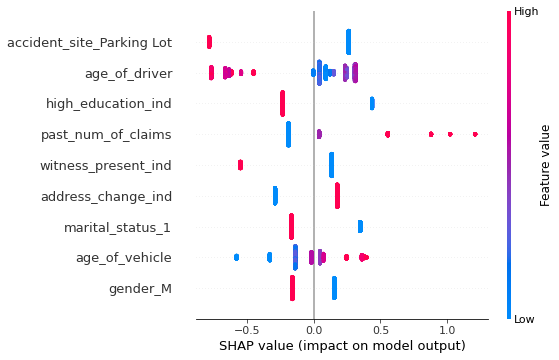

In [ ]:
explainer = shap.TreeExplainer(xgb_model_final)
shap_values = explainer.shap_values(X_test[x_columns])
shap.summary_plot(shap_values, X_test[x_columns])

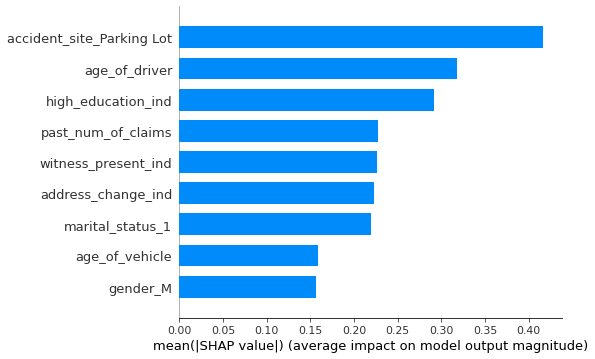

In [ ]:
shap.summary_plot(shap_values, X_test[x_columns], plot_type="bar")

## SVM

In [ ]:
# Use the default SVM (SVM) to determine which sampling method can best improve the model performance
svm = SVC(random_state=1)

# 1. Default SVM without sampling method
print("SVM - No Sampling \n")
no_sampling_perf_svm = evaluate_model(svm, "None", x_columns, evaluate_f1=False)
no_sampling_perf_svm["Model"] = "No Sampling SVM"

# 2. Default SVM with SMOTE sampling method
print("SVM - With SMOTE Sampling Method \n")
smote_sampling_perf_svm = evaluate_model(svm, "SMOTE", x_columns, evaluate_f1=False)
smote_sampling_perf_svm["Model"] = "SMOTE Sampling SVM"

# 3. Default SVM with SMOTE_ENN sampling method
print("SVM - With SMOTE_ENN Sampling Method \n")
smote_enn_sampling_perf_svm = evaluate_model(svm, "SMOTE_ENN", x_columns, evaluate_f1=False)
smote_enn_sampling_perf_svm["Model"] = "SMOTE_ENN Sampling SVM"

# 3. Default SVM with inbuilt class weight sampling method
print("SVM - With Inbuilt Class Weighting Method \n")
svm_weight_model = SVC(random_state=1,class_weight="balanced") 
#The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
class_weighted_sampling_perf_svm = evaluate_model(svm_weight_model, "None", x_columns, evaluate_f1=False)
class_weighted_sampling_perf_svm["Model"] = "Class Weighting Sampling SVM"

SVM - No Sampling 

Confusion Matrix: 
 [[12009     9]
 [ 2217    18]]
TN: 12009, FP: 9, FN: 2217, TP: 18


Accuracy: 0.8438223531888024
Recall: 0.008053691275167786
Precision: 0.6666666666666666
F1: 0.01591511936339523
MCC: 0.06108587181912435
F1_macro: 0.46554786603743603
ROC_AUC: 0.5036524072950976




SVM - With SMOTE Sampling Method 

Confusion Matrix: 
 [[11081   937]
 [ 1821   414]]
TN: 11081, FP: 937, FN: 1821, TP: 414


Accuracy: 0.8064968778502771
Recall: 0.18523489932885906
Precision: 0.306439674315322
F1: 0.2308979364194088
MCC: 0.1331591275390146
F1_macro: 0.560111889558019
ROC_AUC: 0.5536342577855812




SVM - With SMOTE_ENN Sampling Method 

Confusion Matrix: 
 [[5879 6139]
 [ 535 1700]]
TN: 5879, FP: 6139, FN: 535, TP: 1700


Accuracy: 0.5317477022381253
Recall: 0.7606263982102909
Precision: 0.21686439596887358
F1: 0.3375024816358944
MCC: 0.18258648983383421
F1_macro: 0.48770740401239165
ROC_AUC: 0.6249046452692326




SVM - With Inbuilt Class Weighting Method 

Confusi

In [ ]:
perf_summary_svm = [no_sampling_perf_svm, smote_sampling_perf_svm, smote_enn_sampling_perf_svm,class_weighted_sampling_perf_svm]
perf_summary_svm_df = pd.DataFrame.from_dict(perf_summary_svm, orient='columns')
perf_summary_svm_df = perf_summary_svm_df.sort_values(['F1'] , ascending=False)
perf_summary_svm_df

,Accuracy,Recall,Precision,F1,MCC,F1_macro,ROC_AUC,Model
3,0.612292,0.679195,0.239924,0.354590,0.204222,0.538757,0.639522,Class Weighting Sampling SVM
2,0.531748,0.760626,0.216864,0.337502,0.182586,0.487707,0.624905,SMOTE_ENN Sampling SVM
1,0.806497,0.185235,0.306440,0.230898,0.133159,0.560112,0.553634,SMOTE Sampling SVM
0,0.843822,0.008054,0.666667,0.015915,0.061086,0.465548,0.503652,No Sampling SVM


### SVM Hyperparameter Tuning

In [ ]:
svm_param_hyperopt = {
        'kernel': hp.choice('kernel', ['rbf','poly','sigmoid','linear']), #poly, sigmoid
        'C': hp.choice('C', [0.1,1,10,100]),
        'degree': hp.choice('degree', [1,2,3,4,5]),
        'gamma': hp.choice('gamma', [1,0.1, 0.01, 0.001]),
        'class_weight': hp.choice('class_weight', ['balanced'])
    }

In [ ]:
#Class Weighting Sampling SVM gives the best F1 score
svm_hyperopt_weighting = load_model(svm_param_hyperopt, 50, "None", SVC, x_columns, 'Tuning/svm_hyperopt_smote.pkl', False) # change to True if load model directly from the Tuning folder
weighting_svm_result = show_tuning_result(svm_hyperopt_weighting)
weighting_svm_result.sort_values(by='loss')[:10]

100%|██████████| 50/50 [46:53<00:00, 56.28s/it, best loss: -0.3556581986143187]


,loss,C,class_weight,degree,gamma,kernel
27,-0.355658,[1],[0],[0],[2],[2]
15,-0.355658,[1],[0],[3],[2],[2]
35,-0.355658,[1],[0],[0],[2],[2]
33,-0.355658,[1],[0],[0],[2],[2]
31,-0.355658,[1],[0],[0],[2],[2]
30,-0.355658,[1],[0],[0],[2],[2]
28,-0.355658,[1],[0],[0],[2],[2]
26,-0.355658,[1],[0],[3],[2],[2]
21,-0.355382,[1],[0],[3],[2],[0]
22,-0.355382,[1],[0],[3],[2],[0]


In [ ]:
kf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

def evaluate_svm(selected_model, sampling_method, x_var_list, evaluate_f1=False, print_result=True):
  x_var = x_var_list
  y_var = 'fraud'
  all_y_preds = [] # predictions
  all_y_true = [] # true labels

  for train_index, test_index in kf.split(X_train[x_var], y_train[y_var]):
    X_train_set, X_test_set = X_train.iloc[train_index][x_var], X_train.iloc[test_index][x_var]
    y_train_set, y_test_set = y_train.iloc[train_index][y_var], y_train.iloc[test_index][y_var]

    # Assign the classifier here
    model = selected_model

    # SMOTE oversampling
    if sampling_method == "SMOTE":
      smote_only = SMOTE(random_state=1, sampling_strategy=0.5)
      X_res_smote, y_res_smote = smote_only.fit_resample(X_train_set, y_train_set)
      model.fit(X_res_smote, y_res_smote)

    # Hybrid of SMOTE and ENN
    elif sampling_method == "SMOTE_ENN":
      ennObj = EditedNearestNeighbours(n_neighbors=5)
      smote_only = SMOTE(random_state=1, sampling_strategy=0.5)
      smote_enn = SMOTEENN(smote=smote_only, enn= ennObj)
      X_res_smoteENN, y_res_smoteENN = smote_enn.fit_resample(X_train_set, y_train_set)
      model.fit(X_res_smoteENN, y_res_smoteENN)

    else:
      model.fit(X_train_set.values, y_train_set)

    y_preds = model.predict(X_test_set.values)
    all_y_preds.extend(y_preds)
    all_y_true.extend(y_test_set)  
  
  if evaluate_f1:
    return(f1_score(all_y_true, all_y_preds))
  else:
    return evaluate_results(all_y_true, all_y_preds, print_result)

In [ ]:
svm_model_final = SVC(
    kernel='sigmoid',
    C=1,
    degree=1, 
    gamma=0.01, 
    random_state=1,
    class_weight='balanced')

evaluate_svm(svm_model_final, "None", x_columns, evaluate_f1=False) #previously was 0.342, 0.35

Confusion Matrix: 
 [[7489 4529]
 [ 772 1463]]
TN: 7489, FP: 4529, FN: 772, TP: 1463


Accuracy: 0.6280782993054094
Recall: 0.654586129753915
Precision: 0.2441588785046729
F1: 0.3556581986143187
MCC: 0.20458927181586065
F1_macro: 0.5471273881774192
ROC_AUC: 0.6388673700858108






{'Accuracy': 0.6280782993054094,
 'Recall': 0.654586129753915,
 'Precision': 0.2441588785046729,
 'F1': 0.3556581986143187,
 'MCC': 0.20458927181586065,
 'F1_macro': 0.5471273881774192,
 'ROC_AUC': 0.6388673700858108}

### SVM Model on Test Data

In [ ]:
#SVM Model on Test Data
model_test_data_perf(svm_model_final, "None", x_columns)

X has feature names, but SVC was fitted without feature names


Confusion Matrix: 
 [[1824 1181]
 [ 199  360]]
TN: 1824, FP: 1181, FN: 199, TP: 360


Accuracy: 0.6127946127946128
Recall: 0.6440071556350626
Precision: 0.2336145360155743
F1: 0.34285714285714286
MCC: 0.18424462676281098
F1_macro: 0.5341970678486192
ROC_AUC: 0.6254977541902434






In [ ]:
explainer = shap.KernelExplainer(svm_model_final.predict,shap.kmeans(X_test[x_columns].values,100))

In [ ]:
import warnings
import os
warnings.filterwarnings("ignore")
shap_values_svm = explainer.shap_values(X_test[x_columns], nsamples=100)

  0%|          | 0/3564 [00:00<?, ?it/s]

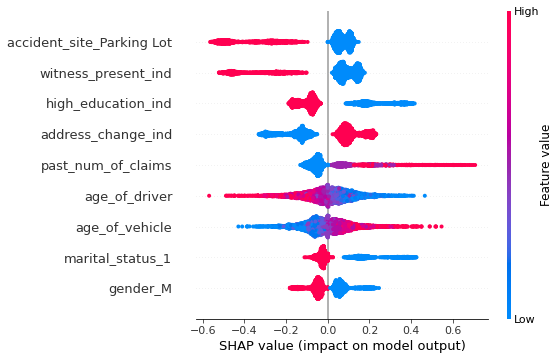

In [ ]:
shap.summary_plot(shap_values_svm, X_test[x_columns])

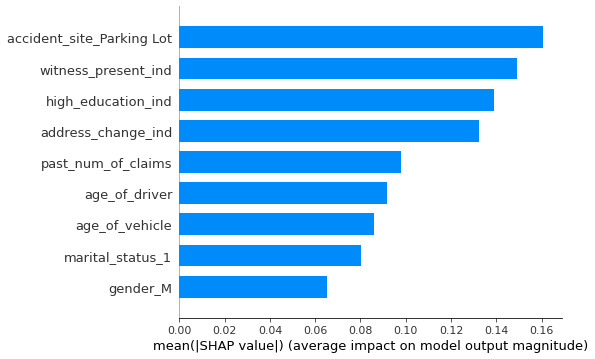

In [ ]:
shap.summary_plot(shap_values_svm, X_test[x_columns], plot_type="bar")

## Neural Network

### Setting up helper functions and variables

In [ ]:
# Setting up configuration

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

BATCH_SIZE = 2048
EPOCHS = 200
input_dim = X_train[x_columns].shape[-1]
verbose = 0

In [ ]:
kf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

def evaluate_NN(sampling_method, x_var_list, evaluate_f1=False, print_result=True, verbose=2):
    x_var = x_var_list
    y_var = 'fraud'
    all_y_preds = [] # predictions
    all_y_true = [] # true labels

    for train_index, test_index in kf.split(X_train[x_var], y_train[y_var]):
        X_train_set, X_test_set = X_train.iloc[train_index][x_var], X_train.iloc[test_index][x_var]
        y_train_set, y_test_set = y_train.iloc[train_index][y_var], y_train.iloc[test_index][y_var]

        # Generating a new base NN model
        model = make_base_NN_model()

        # SMOTE oversampling
        if sampling_method == "SMOTE":
            smote_only = SMOTE(random_state=1, sampling_strategy=0.5)
            X_res_smote, y_res_smote = smote_only.fit_resample(X_train_set, y_train_set)
            X_fit = X_res_smote.copy()
            y_fit = y_res_smote.copy()

        # Hybrid of SMOTE and ENN
        elif sampling_method == "SMOTE_ENN":
            ennObj = EditedNearestNeighbours(n_neighbors=5)
            smote_only = SMOTE(random_state=1, sampling_strategy=0.5)
            smote_enn = SMOTEENN(smote=smote_only, enn= ennObj)
            X_res_smoteENN, y_res_smoteENN = smote_enn.fit_resample(X_train_set, y_train_set)
            X_fit = X_res_smoteENN.copy()
            y_fit = y_res_smoteENN.copy()

        else:
            X_fit = X_train_set.copy()
            y_fit = y_train_set.copy()

        if sampling_method == 'class_weight':
            # Setting weights according to proportion of true/false in training set
            weight_for_0 = 1.0 / y_train_set.value_counts()[0]
            weight_for_1 = 1.0 / y_train_set.value_counts()[1]
            class_weight = {0: weight_for_0, 1: weight_for_1}

            model.fit(
                X_fit,
                y_fit,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                verbose=verbose,
                callbacks=[early_stopping],
                class_weight=class_weight,
                validation_data=(X_test_set, y_test_set),
            )
        else:
            model.fit(
                X_fit,
                y_fit,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                verbose=verbose,
                callbacks=[early_stopping],
                validation_data=(X_test_set, y_test_set),
            )

        y_preds = model.predict(X_test_set)
        y_preds = np.where(y_preds > 0.5, 1,0)
        all_y_preds.extend(y_preds)
        all_y_true.extend(y_test_set)  
    
    if evaluate_f1:
        return(f1_score(all_y_true, all_y_preds))
    else:
        return evaluate_results(all_y_true, all_y_preds, print_result)

### Use a baseline NN to determine which sampling method can best improve the model performance

In [ ]:
def make_base_NN_model():
    model = Sequential(
    [
       Dense(
            256, activation="relu", input_shape=(input_dim,)
        ),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid"),
    ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=METRICS
    )

    return model

In [ ]:
# Previewing model summary
baseline_NN = make_base_NN_model()
baseline_NN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               2560      
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 257       
                                                                 
Total params: 134,401
Trainable params: 134,401
Non-tr

In [ ]:
# Use the default NN to determine which sampling method can best improve the model performance

# 1. Default NN without sampling method
print("NN - No Sampling \n")
no_sampling_perf_nn = evaluate_NN("None", x_columns, evaluate_f1=False, verbose=verbose)
no_sampling_perf_nn["Model"] = "No Sampling NN"

# 2. Default NN with SMOTE sampling method
print("NN - With SMOTE Sampling Method \n")
smote_sampling_perf_nn = evaluate_NN("SMOTE", x_columns, evaluate_f1=False, verbose=verbose)
smote_sampling_perf_nn["Model"] = "SMOTE Sampling NN"

# 3. Default NN with SMOTE_ENN sampling method
print("SVM - With SMOTE_ENN Sampling Method \n")
smote_enn_sampling_perf_nn = evaluate_NN("SMOTE_ENN", x_columns, evaluate_f1=False, verbose=verbose)
smote_enn_sampling_perf_nn["Model"] = "SMOTE_ENN Sampling NN"

# 4. Default NN with inbuilt class weight sampling method
print("NN - With Inbuilt Class Weighting Method \n")
class_weighted_sampling_perf_nn = evaluate_NN("class_weight", x_columns, evaluate_f1=False, verbose=verbose)
class_weighted_sampling_perf_nn["Model"] = "Class Weighting Sampling NN"

NN - No Sampling 

Restoring model weights from the end of the best epoch: 5.
Epoch 25: early stopping
90/90 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 30.
Epoch 50: early stopping
90/90 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 16.
Epoch 36: early stopping
90/90 [==============================] - 0s 3ms/step
Restoring model weights from the end of the best epoch: 4.
Epoch 24: early stopping
90/90 [==============================] - 0s 3ms/step
Restoring model weights from the end of the best epoch: 4.
Epoch 24: early stopping
90/90 [==============================] - 0s 3ms/step
Confusion Matrix: 
 [[12008    10]
 [ 2212    23]]
TN: 12008, FP: 10, FN: 2212, TP: 23


Accuracy: 0.8441029958605206
Recall: 0.01029082774049217
Precision: 0.696969696969697
F1: 0.020282186948853614
MCC: 0.07156184016937131
F1_macro: 0.4677979270745488
ROC_AUC: 0.5047293712674835




NN - Wit

In [ ]:
perf_summary_nn = [no_sampling_perf_nn, smote_sampling_perf_nn, smote_enn_sampling_perf_nn,class_weighted_sampling_perf_nn]
perf_summary_nn_df = pd.DataFrame.from_dict(perf_summary_nn, orient='columns')
perf_summary_nn_df = perf_summary_nn_df.sort_values(['F1'] , ascending=False)
perf_summary_nn_df

,Accuracy,Recall,Precision,F1,MCC,F1_macro,ROC_AUC,Model
3,0.621904,0.672931,0.244077,0.358223,0.209442,0.545117,0.642673,Class Weighting Sampling NN
2,0.552375,0.755257,0.224438,0.346043,0.196585,0.502888,0.634951,SMOTE_ENN Sampling NN
1,0.797376,0.292170,0.333333,0.311397,0.193788,0.596304,0.591750,SMOTE Sampling NN
0,0.844103,0.010291,0.696970,0.020282,0.071562,0.467798,0.504729,No Sampling NN


### Hyperparameter tuning for best performing method

In [ ]:
# Splitting train and validation data
X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(X_train, y_train, test_size=0.2, random_state=1, stratify=y_train)

X_train_NN = X_train_NN[x_columns]
X_val_NN = X_val_NN[x_columns]

In [ ]:
class NN_Model(kt.HyperModel):

    def build(self, hp):
        model = Sequential()

        model.add(Dense(units = hp.Int('dense-bot', min_value=16, max_value=512, step=16), input_shape=(input_dim,), activation='relu'))

        for i in range(hp.Int('num_dense_layers', 1, 4)):
            model.add(Dense(units=hp.Int('dense_' + str(i), min_value=16, max_value=512, step=16), activation='relu'))
            model.add(Dropout(hp.Choice('dropout_'+ str(i), values=[0.0, 0.1, 0.2, 0.3,0.4])))

        model.add(Dense(1,activation="sigmoid"))

        lr = hp.Choice("learning_rate",
        values=[1e-1, 1e-2, 1e-3])
        
        opt = tf.keras.optimizers.Adam(learning_rate=lr)

        model.compile(optimizer = opt, loss='binary_crossentropy', metrics=METRICS)
        return model

    def fit(self, hp, model, X, y, class_weight, epochs, callbacks, validation_data):
        return model.fit(
            X,
            y,
            batch_size=hp.Int('batch-size', min_value=128, max_value=4096, step=128),
            epochs=epochs,
            class_weight = class_weight,
            callbacks=callbacks,
            validation_data=validation_data
        )


In [ ]:
weight_for_0 = 1.0 / y_train_NN.value_counts()[0]
weight_for_1 = 1.0 / y_train_NN.value_counts()[1]
class_weight = {0: weight_for_0, 1: weight_for_1}


tuner = kt.tuners.BayesianOptimization(
    NN_Model(),
    seed=11,
    objective=kt.Objective("val_prc", direction="max"),
    max_trials=50,
    directory='.',
    project_name='tuning-nn'
)

tuner.search(X = X_train_NN, 
             y = y_train_NN, 
             epochs=EPOCHS,  
             class_weight = class_weight,
             validation_data = (X_val_NN,y_val_NN), 
             callbacks=[early_stopping])

In [ ]:
# Getting best parameters
tuner.results_summary(1)

Results summary
Results in ./tuning-nn
Showing 1 best trials
Trial summary
Hyperparameters:
dense-bot: 512
num_dense_layers: 4
dense_0: 16
dropout_0: 0.0
learning_rate: 0.1
dense_1: 512
dropout_1: 0.4
batch-size: 4096
dense_2: 16
dropout_2: 0.4
dense_3: 512
dropout_3: 0.4
Score: 0.2931559681892395


### Best NN model evaluation

In [ ]:
def make_best_NN_model():
    best_nn_model = Sequential()

    #dense-bot
    best_nn_model.add(Dense(512, input_shape=(input_dim,), activation='relu'))

    #dense-0
    best_nn_model.add(Dense(16, activation='relu'))

    #dense-1
    best_nn_model.add(Dense(512, activation='relu'))
    best_nn_model.add(Dropout(0.4))

    #dense-2
    best_nn_model.add(Dense(16, activation='relu'))
    best_nn_model.add(Dropout(0.4))

    #dense-3
    best_nn_model.add(Dense(512, activation='relu'))
    best_nn_model.add(Dropout(0.4))

    best_nn_model.add(Dense(1,activation="sigmoid"))

    lr = 0.1

    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    best_nn_model.compile(optimizer = opt, loss='binary_crossentropy', metrics=METRICS)

    return best_nn_model

best_nn_model = make_best_NN_model()
best_nn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               5120      
                                                                 
 dense_1 (Dense)             (None, 16)                8208      
                                                                 
 dense_2 (Dense)             (None, 512)               8704      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 16)                8208      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 512)              

In [ ]:
kf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

x_var = x_columns
y_var = 'fraud'
all_y_preds = [] # predictions
all_y_true = [] # true labels

for train_index, test_index in kf.split(X_train[x_var], y_train[y_var]):
    X_train_set, X_test_set = X_train.iloc[train_index][x_var], X_train.iloc[test_index][x_var]
    y_train_set, y_test_set = y_train.iloc[train_index][y_var], y_train.iloc[test_index][y_var]

    # Generating a new base NN model
    model = make_best_NN_model()

    X_fit = X_train_set.copy()
    y_fit = y_train_set.copy()

    # Setting weights according to proportion of true/false in training set
    weight_for_0 = 1.0 / y_train_set.value_counts()[0]
    weight_for_1 = 1.0 / y_train_set.value_counts()[1]
    class_weight = {0: weight_for_0, 1: weight_for_1}

    model.fit(
        X_fit,
        y_fit,
        batch_size=4096,
        epochs=EPOCHS,
        verbose=0,
        callbacks=[early_stopping],
        class_weight=class_weight,
        validation_data=(X_test_set, y_test_set),
    )
    

    y_preds = model.predict(X_test_set)
    y_preds = np.where(y_preds > 0.5, 1,0)
    all_y_preds.extend(y_preds)
    all_y_true.extend(y_test_set)  

evaluate_results(all_y_true, all_y_preds, print_result=False)


Restoring model weights from the end of the best epoch: 25.
Epoch 45: early stopping
90/90 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 25.
Epoch 45: early stopping
90/90 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 26.
Epoch 46: early stopping
90/90 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 24.
Epoch 44: early stopping
90/90 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 19.
Epoch 39: early stopping
90/90 [==============================] - 0s 2ms/step


{'Accuracy': 0.6549498351224303,
 'Recall': 0.6062639821029083,
 'Precision': 0.25125162247357685,
 'F1': 0.3552700576822234,
 'MCC': 0.202636362993001,
 'F1_macro': 0.5598555480479324,
 'ROC_AUC': 0.6351339880559475}

In [ ]:
# predict on test data
weight_for_0 = 1.0 / y_train_NN.value_counts()[0]
weight_for_1 = 1.0 / y_train_NN.value_counts()[1]
class_weight = {0: weight_for_0, 1: weight_for_1}

best_nn_model = make_best_NN_model()
best_nn_model_history = best_nn_model.fit(
    X_train_NN,
    y_train_NN,
    batch_size=4096,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping],
    validation_data=(X_val_NN, y_val_NN),
    class_weight = class_weight
)

y_test_pred = best_nn_model.predict(X_test[x_columns])
y_test_pred = np.where(y_test_pred > 0.5, 1,0)

evaluate_results(y_test, y_test_pred, print_result=False)

Restoring model weights from the end of the best epoch: 33.
Epoch 53: early stopping
112/112 [==============================] - 0s 2ms/step


{'Accuracy': 0.6902356902356902,
 'Recall': 0.5044722719141324,
 'Precision': 0.25428313796212804,
 'F1': 0.3381294964028777,
 'MCC': 0.18008312832987947,
 'F1_macro': 0.5679658471025377,
 'ROC_AUC': 0.6146321426126402}

### Feature Importance

In [ ]:
explainer = shap.KernelExplainer(best_nn_model, shap.sample(X_test[x_columns].values,100))

In [ ]:
shap_values = explainer.shap_values(shap.sample(X_test[x_columns].values,100), nsamples=50)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

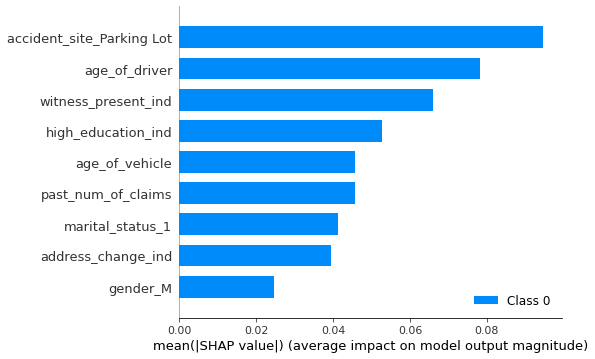

In [ ]:
shap.summary_plot(shap_values, X_test[x_columns])

In [ ]:
shap.initjs()
# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = x_columns)